<a href="https://colab.research.google.com/github/hsunsmile/ml-notebooks/blob/main/nvidia-rag/Problem_01_AI_Assisted_Learning_for_NVIDIA_SDKs_and_Toolkits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparation

In [1]:
%%capture gpu_type
![[ $(which nvidia-smi) ]] && nvidia-smi --query-gpu=gpu_name --format=csv | tail -1 | tr " " _ || echo "cpu"

In [2]:
if str(gpu_type).strip() == 'cpu':
  raise Exception("Please run this notebook on a GPU runtime")

# NVIDIA_A100-SXM4-40GB, 6912 cores
# V100 5120 cores
# T4 128 cores

print(gpu_type)

NVIDIA_A100-SXM4-40GB



### Hyper parameters for the app
One can change LLM models here to try different models easily.

In [3]:
llm_model_name = 'meta-llama/Llama-2-13b-chat-hf'
# llm_model_name = 'mistralai/Mistral-7B-v0.1'
# llm_model_name = 'meta-llama/Llama-2-7b-chat-hf'

pipeline_type = "text-generation"
enable_multi_query = False

questions = [
    "what is the nvidia CUDA toolkit?",
    "what do you know about the nvidia CUDA toolkit?",
    "How can I install the NVIDIA cuda toolkit on windows?",
    "What steps to follow to install the NVIDIA cuda toolkit on windows?",
    "what is the differences between nvida's BioMegatron and Megatron 530B LLM?",
    "How can I install the NVIDIA cuda toolkit on Mac OSX with M2 processor?",
    "What steps to follow to install the NVIDIA cuda toolkit on Mac OSX with M2 processor?",
    "What is cublas, how to use it?",
    "What is Nvidia cublas library?",
    "How to use cublas"
]

### Mounting google drive

A cache_folder is used to store crawling results and vectore store artifacts.

In [4]:
from google.colab import drive
drive.mount('/content/drive')
cache_folder = '/content/drive/MyDrive/ML_artifacts'

Mounted at /content/drive


### Notebook preparation

In [5]:
import os
from google.colab import userdata
hf_token = userdata.get('HF_TOKEN')

import logging
logging.basicConfig()
logging.getLogger("langchain.retrievers.multi_query").setLevel(logging.INFO)

In [6]:
!pip install -q accelerate==0.21.0 transformers==4.34.0 tokenizers==0.14.1
!pip install -q bitsandbytes==0.40.0 einops==0.6.1
!pip install -q xformers==0.0.22.post7
!pip install -q langchain==0.1.4
!pip install -q faiss-gpu==1.7.1.post3
!pip install -q sentence_transformers==2.2.2 FlagEmbedding

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 81.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 101.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.9/91.9 MB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.8/211.8 MB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.6/803.6 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 81.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.4/246.4 kB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

### Define functions for model loading

#### Experimental function
This function is introduced to reduce the answer length, so it is concise and taking less time to run. This wasn't a successful one, just put in place for reporting and further discussion

In [7]:
from transformers import LogitsProcessor
import torch

class EosTokenRewardLogitsProcessor(LogitsProcessor):
  def __init__(self,  eos_token_id: int, max_length: int):

        if not isinstance(eos_token_id, int) or eos_token_id < 0:
            raise ValueError(f"`eos_token_id` has to be a positive integer, but is {eos_token_id}")

        if not isinstance(max_length, int) or max_length < 1:
          raise ValueError(f"`max_length` has to be a integer bigger than 1, but is {max_length}")

        self.eos_token_id = eos_token_id
        self.max_length=max_length

  def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor) -> torch.FloatTensor:
    cur_len = input_ids.shape[-1]
    # start to increese the reward of the  eos_tokekn from 80% max length  progressively on length
    for cur_len in (max(0,int(self.max_length*0.8)), self.max_length ):
      ratio = cur_len/self.max_length
      num_tokens = scores.shape[1] # size of vocab
      scores[:, [i for i in range(num_tokens) if i != self.eos_token_id]] =\
      scores[:, [i for i in range(num_tokens) if i != self.eos_token_id]]*ratio*10*torch.exp(-torch.sign(scores[:, [i for i in range(num_tokens) if i != self.eos_token_id]]))
      scores[:, self.eos_token_id] = 1e2*ratio
    return scores


#### Define functions for LLM pipeline

In [8]:
from torch import cuda, bfloat16
import transformers

def load_pretrained_model(model_id):
  device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'
  # set quantization configuration to load large model with less GPU memory
  # this requires the `bitsandbytes` library
  bnb_config = transformers.BitsAndBytesConfig(
      load_in_4bit=True,
      bnb_4bit_quant_type='nf4',
      bnb_4bit_use_double_quant=True,
      bnb_4bit_compute_dtype=bfloat16
  )

  model_config = transformers.AutoConfig.from_pretrained(
      model_id,
      token=hf_token
  )

  model = transformers.AutoModelForCausalLM.from_pretrained(
      model_id,
      trust_remote_code=True,
      config=model_config,
      quantization_config=bnb_config,
      device_map='auto',
      token=hf_token
  )
  # enable evaluation mode to allow model inference
  model.eval()
  return model

In [9]:
import torch
from transformers import StoppingCriteria, StoppingCriteriaList
# define custom stopping criteria object
class StopOnTokens(StoppingCriteria):
  def __init__(self, tokenizer):
    super().__init__()
    device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'
    stop_list = ['\nHuman:', '\n```\n']
    stop_token_ids = [tokenizer(x)['input_ids'] for x in stop_list]
    self.stop_token_ids = [torch.LongTensor(x).to(device) for x in stop_token_ids]

  def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor, **kwargs) -> bool:
      for stop_ids in self.stop_token_ids:
          if torch.eq(input_ids[0][-len(stop_ids):], stop_ids).all():
              return True
      return False

In [10]:
def quantizized_model_pipeline(model_id, pipeline_type):
  model = load_pretrained_model(model_id)
  tokenizer = transformers.AutoTokenizer.from_pretrained(
      model_id,
      token=hf_token
  )
  stopping_criteria = StoppingCriteriaList([StopOnTokens(tokenizer)])
  generate_text = transformers.pipeline(
      model=model,
      tokenizer=tokenizer,
      return_full_text=True,  # langchain expects the full text
      task=pipeline_type,
      # we pass model parameters here too
      stopping_criteria=stopping_criteria,  # without this model rambles during chat
      # logits_processor=[EosTokenRewardLogitsProcessor(tokenizer.eos_token_id, 1200)],  # without this model rambles during chat
      temperature=0.0001,  # 'randomness' of outputs, 0.0 is the min and 1.0 the max
      max_new_tokens=300,  # max number of tokens to generate in the output
      repetition_penalty=1.1,  # without this output begins repeating
  )

  return generate_text

def lighter_model_pipeline(model_id, pipeline_type):
  return transformers.pipeline(
      pipeline_type,
      model=model_id,
      torch_dtype=torch.bfloat16,
      device_map="auto")

def create_pipeline(model_id, pipeline_type):
  if model_id.startswith("TinyLlama"):
    return lighter_model_pipeline(model_id, pipeline_type)
  elif model_id.startswith("meta-llama"):
    return quantizized_model_pipeline(model_id, pipeline_type)

  raise Exception(f"model_id: {model_id} is not supported")
  return None

#### Run LLM pipeline

In [11]:
generate_text = create_pipeline(llm_model_name, pipeline_type)


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda122.so


/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: /usr/lib64-nvidia did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/sys/fs/cgroup/memory.events /var/colab/cgroup/jupyter-children/memory.events')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('//172.28.0.1'), PosixPath('8013'), PosixPath('http')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('//colab.research.google.com/tun/m/cc483011

CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 122
CUDA SETUP: Loading binary /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda122.so...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/utils/hub.py:374: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [12]:
from langchain.llms import HuggingFacePipeline
llm = HuggingFacePipeline(pipeline=generate_text)

In [15]:
import pandas as pd
import time

llm_model = llm_model_name.replace("/", "_")
vanilla_results_file = f"{cache_folder}/vanilla_results_{llm_model}.csv"
if not os.path.exists(vanilla_results_file):
  vanilla_results = []
  for question in questions:
    start = time.time()
    answer = llm.invoke(input=question)
    end = time.time()
    vanilla_results.append({"question": question, "answer": answer, "time": end - start})
    df = pd.DataFrame(vanilla_results)
    df.to_csv(vanilla_results_file, index=False)
else:
  df = pd.read_csv(vanilla_results_file)

df

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


,question,answer,time
0,what is the nvidia CUDA toolkit?,\n\nThe NVIDIA CUDA Toolkit is a set of softwa...,31.170897
1,what do you know about the nvidia CUDA toolkit?,"\n\nI'm looking to use it for a project, but I...",30.916592
2,How can I install the NVIDIA cuda toolkit on w...,\n\nI have a Windows 10 machine and I want to ...,27.327806
3,What steps to follow to install the NVIDIA cud...,\n\nAnswer: Here are the steps to install the ...,31.172142
4,what is the differences between nvida's BioMeg...,\n\nI am looking for a high-performance GPU ac...,31.128656
5,How can I install the NVIDIA cuda toolkit on M...,\n\nI am trying to install the NVIDIA CUDA too...,25.630223
6,What steps to follow to install the NVIDIA cud...,"\n\nI have a MacBook Pro (M2, 2018) and I want...",30.865325
7,"What is cublas, how to use it?",\n\nI'm trying to optimize a deep learning mod...,30.791787
8,What is Nvidia cublas library?,\n\nNVIDIA CUDA is a parallel computing platfo...,25.347608
9,How to use cublas,\n\nI am trying to use the CUDA BLAS (cublas) ...,30.724067


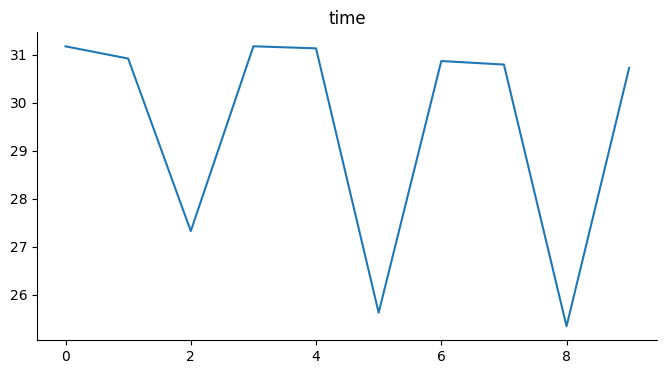

In [16]:
# @title time

from matplotlib import pyplot as plt
df['time'].plot(kind='line', figsize=(8, 4), title='time')
plt.gca().spines[['top', 'right']].set_visible(False)

# RAG application

### Crawl webpages with WebBaseLoader from langchain

#### Webpage links

In [17]:
web_links_cuda = [
  "https://docs.nvidia.com/cuda/",
  "https://docs.nvidia.com/cuda/nvvm-ir-spec/index.html",
  "https://docs.nvidia.com/cuda/incomplete-lu-cholesky/index.html",
  "https://docs.nvidia.com/cuda/libdevice-users-guide/index.html",
  "https://docs.nvidia.com/cuda/libnvvm-api/index.html",
  "https://docs.nvidia.com/cuda/nsight-eclipse-plugins-guide/index.html",
  "https://docs.nvidia.com/cuda/floating-point/index.html",
  "https://docs.nvidia.com/cuda/cuda-for-tegra-appnote/index.html",
  "https://docs.nvidia.com/cuda/vGPU/index.html",
  "https://docs.nvidia.com/cuda/nsightee-plugins-install-guide/index.html",
  "https://docs.nvidia.com/cuda/cuda-binary-utilities/index.html",
  "https://docs.nvidia.com/cuda/cuda-compiler-driver-nvcc/index.html",
  "https://docs.nvidia.com/cuda/profiler-users-guide/index.html",
  "https://docs.nvidia.com/cuda/cuda-gdb/index.html",
  "https://docs.nvidia.com/cuda/debugger-api/index.html",
  "https://docs.nvidia.com/cuda/eflow-users-guide/index.html",
  "https://docs.nvidia.com/cuda/wsl-user-guide/index.html",
  "https://docs.nvidia.com/cuda/demo-suite/index.html",
  "https://docs.nvidia.com/cuda/gpudirect-rdma/index.html",
  "https://docs.nvidia.com/cuda/index.html",
  "https://docs.nvidia.com/cuda/nvvm-ir-spec/contents.html",
  "https://docs.nvidia.com/cuda/ptx-compiler-api/index.html",
  "https://docs.nvidia.com/cuda/thrust/index.html",
  "https://docs.nvidia.com/cuda/nvjitlink/index.html",
  "https://docs.nvidia.com/cuda/nvrtc/index.html",
  "https://docs.nvidia.com/cuda/cusolver/index.html",
  "https://docs.nvidia.com/cuda/nppplus/index.html",
  "https://docs.nvidia.com/cuda/libnvvm-api/contents.html",
  "https://docs.nvidia.com/cuda/nsight-eclipse-plugins-guide/contents.html",
  "https://docs.nvidia.com/cuda/libdevice-users-guide/basic-usage.html",
  "https://docs.nvidia.com/cuda/libdevice-users-guide/introduction.html",
  "https://docs.nvidia.com/cuda/libdevice-users-guide/function-desc.html",
  "https://docs.nvidia.com/cuda/incomplete-lu-cholesky/contents.html",
  "https://docs.nvidia.com/cuda/nsightee-plugins-install-guide/contents.html",
  "https://docs.nvidia.com/cuda/vGPU/contents.html",
  "https://docs.nvidia.com/cuda/cuda-binary-utilities/contents.html",
  "https://docs.nvidia.com/cuda/floating-point/contents.html",
  "https://docs.nvidia.com/cuda/npp/index.html",
  "https://docs.nvidia.com/cuda/cuda-for-tegra-appnote/contents.html",
  "https://docs.nvidia.com/cuda/eflow-users-guide/contents.html",
  "https://docs.nvidia.com/cuda/debugger-api/deprecated.html",
  "https://docs.nvidia.com/cuda/debugger-api/functions.html",
  "https://docs.nvidia.com/cuda/debugger-api/annotated.html",
  "https://docs.nvidia.com/cuda/debugger-api/modules.html",
  "https://docs.nvidia.com/cuda/cuda-compiler-driver-nvcc/contents.html",
  "https://docs.nvidia.com/cuda/thrust/contents.html",
  "https://docs.nvidia.com/cuda/ptx-compiler-api/contents.html",
  "https://docs.nvidia.com/cuda/demo-suite/contents.html",
  "https://docs.nvidia.com/cuda/wsl-user-guide/contents.html",
  "https://docs.nvidia.com/cuda/nvjitlink/contents.html",
  "https://docs.nvidia.com/cuda/debugger-api/r_main.html",
  "https://docs.nvidia.com/cuda/gpudirect-rdma/contents.html",
  "https://docs.nvidia.com/cuda/debugger-api/release-notes.html",
  "https://docs.nvidia.com/cuda/nppplus/search.html",
  "https://docs.nvidia.com/cuda/cuda-gdb/contents.html",
  "https://docs.nvidia.com/cuda/profiler-users-guide/contents.html",
  "https://docs.nvidia.com/cuda/cufft/index.html",
  "https://docs.nvidia.com/cuda/nvrtc/contents.html",
  "https://docs.nvidia.com/cuda/curand/index.html",
  "https://docs.nvidia.com/cuda/cusparse/index.html",
  "https://docs.nvidia.com/cuda/nppplus/signal_initialization.html",
  "https://docs.nvidia.com/cuda/nppplus/signal_statistical_functions.html",
  "https://docs.nvidia.com/cuda/nppplus/genindex.html",
  "https://docs.nvidia.com/cuda/nppplus/signal_conversion_functions.html",
  "https://docs.nvidia.com/cuda/nppplus/signal_memory_management.html",
  "https://docs.nvidia.com/cuda/nppplus/signal_filtering_functions.html",
  "https://docs.nvidia.com/cuda/nppplus/signal_arithmetic_and_logical_operations.html",
  "https://docs.nvidia.com/cuda/npp/search.html",
  "https://docs.nvidia.com/cuda/debugger-api/notices-header.html",
  "https://docs.nvidia.com/cuda/npp/signal_memory_management.html",
  "https://docs.nvidia.com/cuda/nppplus/image_memory_management.html",
  "https://docs.nvidia.com/cuda/npp/signal_initialization.html",
  "https://docs.nvidia.com/cuda/npp/signal_filtering_functions.html",
  "https://docs.nvidia.com/cuda/npp/genindex.html",
  "https://docs.nvidia.com/cuda/npp/signal_statistical_functions.html",
  "https://docs.nvidia.com/cuda/npp/signal_arithmetic_and_logical_operations.html",
  "https://docs.nvidia.com/cuda/npp/signal_conversion_functions.html",
  "https://docs.nvidia.com/cuda/npp/image_memory_management.html",
  "https://docs.nvidia.com/cuda/npp/image_threshold_and_compare_operations.html",
  "https://docs.nvidia.com/cuda/npp/image_morphological_operations.html",
  "https://docs.nvidia.com/cuda/npp/image_linear_transforms.html",
  "https://docs.nvidia.com/cuda/curand/testing.html",
  "https://docs.nvidia.com/cuda/curand/bibliography.html",
  "https://docs.nvidia.com/cuda/curand/modules.html",
  "https://docs.nvidia.com/cuda/curand/acknowledgements.html",
  "https://docs.nvidia.com/cuda/curand/device-api-overview.html",
  "https://docs.nvidia.com/cuda/npp/image_geometry_transforms.html",
  "https://docs.nvidia.com/cuda/npp/image_statistics_functions.html",
  "https://docs.nvidia.com/cuda/curand/host-api-overview.html",
  "https://docs.nvidia.com/cuda/cusparse/contents.html",
  "https://docs.nvidia.com/cuda/npp/core_npp.html",
  "https://docs.nvidia.com/cuda/curand/notices-header.html",
  "https://docs.nvidia.com/cuda/nppplus/core_npp.html",
  "https://docs.nvidia.com/cuda/nppplus/image_filtering_functions_private.html",
  "https://docs.nvidia.com/cuda/curand/introduction.html",
  "https://docs.nvidia.com/cuda/curand/compatibility-and-versioning.html",
  "https://docs.nvidia.com/cuda/npp/image_filtering_functions_private.html",
  "https://docs.nvidia.com/cuda/cufft/contents.html",
  "https://docs.nvidia.com/cuda/npp/nppdefs.html",
  "https://docs.nvidia.com/cuda/nppplus/image_threshold_and_compare_operations.html",
  "https://docs.nvidia.com/cuda/npp/image_data_exchange_and_initialization.html",
  "https://docs.nvidia.com/cuda/nppplus/image_statistics_functions.html",
  "https://docs.nvidia.com/cuda/nppplus/image_linear_transforms.html",
  "https://docs.nvidia.com/cuda/nppplus/image_morphological_operations.html",
  "https://docs.nvidia.com/cuda/npp/image_arithmetic_and_logical_operations.html",
  "https://docs.nvidia.com/cuda/nppplus/image_geometry_transforms.html",
  "https://docs.nvidia.com/cuda/npp/image_filtering_functions.html",
  "https://docs.nvidia.com/cuda/npp/image_color_conversion.html",
  "https://docs.nvidia.com/cuda/nppplus/image_filtering_functions.html",
  "https://docs.nvidia.com/cuda/nppplus/image_color_conversion.html",
  "https://docs.nvidia.com/cuda/nppplus/image_data_exchange_and_initialization.html",
  "https://docs.nvidia.com/cuda/npp/introduction.html",
  "https://docs.nvidia.com/cuda/nppplus/nppdefs.html",
  "https://docs.nvidia.com/cuda/nppplus/introduction.html",
  "https://docs.nvidia.com/cuda/nvjpeg/index.html",
  "https://docs.nvidia.com/cuda/nppplus/image_arithmetic_and_logical_operations.html",
  "https://docs.nvidia.com/cuda/cudla-api/index.html",
  "https://docs.nvidia.com/cuda/cusolver/contents.html",
  "https://docs.nvidia.com/cuda/nvblas/index.html",
  "https://docs.nvidia.com/cuda/cublas/index.html",
  "https://docs.nvidia.com/cuda/nvjpeg/contents.html",
  "https://docs.nvidia.com/cuda/ptx-writers-guide-to-interoperability/index.html",
  "https://docs.nvidia.com/cuda/inline-ptx-assembly/index.html",
  "https://docs.nvidia.com/cuda/cublas/contents.html",
  "https://docs.nvidia.com/cuda/cuda-math-api/index.html",
  "https://docs.nvidia.com/cuda/cuda-driver-api/index.html",
  "https://docs.nvidia.com/cuda/cuda-runtime-api/index.html",
  "https://docs.nvidia.com/cuda/video-decoder/index.html",
  "https://docs.nvidia.com/cuda/nvblas/contents.html",
  "https://docs.nvidia.com/cuda/optimus-developer-guide/index.html",
  "https://docs.nvidia.com/cuda/ada-tuning-guide/index.html",
  "https://docs.nvidia.com/cuda/ampere-tuning-guide/index.html",
  "https://docs.nvidia.com/cuda/hopper-tuning-guide/index.html",
  "https://docs.nvidia.com/cuda/volta-tuning-guide/index.html",
  "https://docs.nvidia.com/cuda/turing-tuning-guide/index.html",
  "https://docs.nvidia.com/cuda/maxwell-tuning-guide/index.html",
  "https://docs.nvidia.com/cuda/ampere-compatibility-guide/index.html",
  "https://docs.nvidia.com/cuda/pascal-tuning-guide/index.html",
  "https://docs.nvidia.com/cuda/ada-compatibility-guide/index.html",
  "https://docs.nvidia.com/cuda/hopper-compatibility-guide/index.html",
  "https://docs.nvidia.com/cuda/turing-compatibility-guide/index.html",
  "https://docs.nvidia.com/cuda/volta-compatibility-guide/index.html",
  "https://docs.nvidia.com/cuda/pascal-compatibility-guide/index.html",
  "https://docs.nvidia.com/cuda/maxwell-compatibility-guide/index.html",
  "https://docs.nvidia.com/cuda/parallel-thread-execution/index.html",
  "https://docs.nvidia.com/cuda/cuda-installation-guide-linux/index.html",
  "https://docs.nvidia.com/cuda/eula/index.html",
  "https://docs.nvidia.com/cuda/cuda-installation-guide-microsoft-windows/index.html",
  "https://docs.nvidia.com/cuda/cuda-quick-start-guide/index.html",
  "https://docs.nvidia.com/cuda/cuda-c-best-practices-guide/index.html",
  "https://docs.nvidia.com/cuda/cuda-driver-api/deprecated.html",
  "https://docs.nvidia.com/cuda/cuda-driver-api/functions.html",
  "https://docs.nvidia.com/cuda/ampere-compatibility-guide/contents.html",
  "https://docs.nvidia.com/cuda/hopper-tuning-guide/contents.html",
  "https://docs.nvidia.com/cuda/maxwell-tuning-guide/contents.html",
  "https://docs.nvidia.com/cuda/ada-tuning-guide/contents.html",
  "https://docs.nvidia.com/cuda/volta-tuning-guide/contents.html",
  "https://docs.nvidia.com/cuda/turing-tuning-guide/contents.html",
  "https://docs.nvidia.com/cuda/ampere-tuning-guide/contents.html",
  "https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html",
  "https://docs.nvidia.com/cuda/cuda-runtime-api/deprecated.html",
  "https://docs.nvidia.com/cuda/cuda-runtime-api/annotated.html",
  "https://docs.nvidia.com/cuda/cuda-runtime-api/functions.html",
  "https://docs.nvidia.com/cuda/optimus-developer-guide/contents.html",
  "https://docs.nvidia.com/cuda/cuda-runtime-api/unioncudaLaunchAttributeValue.html",
  "https://docs.nvidia.com/cuda/video-decoder/contents.html",
  "https://docs.nvidia.com/cuda/cuda-runtime-api/modules.html",
  "https://docs.nvidia.com/cuda/cuda-runtime-api/version-mixing-rules.html",
  "https://docs.nvidia.com/cuda/maxwell-compatibility-guide/contents.html",
  "https://docs.nvidia.com/cuda/cuda-installation-guide-linux/contents.html",
  "https://docs.nvidia.com/cuda/parallel-thread-execution/contents.html",
  "https://docs.nvidia.com/cuda/volta-compatibility-guide/contents.html",
  "https://docs.nvidia.com/cuda/eula/contents.html",
  "https://docs.nvidia.com/cuda/pascal-compatibility-guide/contents.html",
  "https://docs.nvidia.com/cuda/cuda-installation-guide-linux/copyright.html",
  "https://docs.nvidia.com/cuda/cuda-driver-api/notices-header.html",
  "https://docs.nvidia.com/cuda/cuda-c-best-practices-guide/contents.html",
  "https://docs.nvidia.com/cuda/turing-compatibility-guide/contents.html",
  "https://docs.nvidia.com/cuda/cuda-runtime-api/stream-sync-behavior.html",
  "https://docs.nvidia.com/cuda/ada-compatibility-guide/contents.html",
  "https://docs.nvidia.com/cuda/cuda-runtime-api/graphs-thread-safety.html",
  "https://docs.nvidia.com/cuda/hopper-compatibility-guide/contents.html",
  "https://docs.nvidia.com/cuda/pascal-tuning-guide/contents.html",
  "https://docs.nvidia.com/cuda/cuda-installation-guide-microsoft-windows/contents.html",
  "https://docs.nvidia.com/cuda/cuda-quick-start-guide/contents.html",
  "https://docs.nvidia.com/cuda/cuda-c-programming-guide/contents.html",
  "https://docs.nvidia.com/cuda/cuda-runtime-api/driver-vs-runtime-api.html",
  "https://docs.nvidia.com/cuda/cuda-runtime-api/api-sync-behavior.html",
  "https://docs.nvidia.com/cuda/cuda-driver-api/version-mixing-rules.html",
  "https://docs.nvidia.com/cuda/cuda-driver-api/modules.html",
  "https://docs.nvidia.com/cuda/cuda-driver-api/annotated.html",
  "https://docs.nvidia.com/cuda/cuda-driver-api/unionCUlaunchAttributeValue.html",
  "https://docs.nvidia.com/cuda/cuda-driver-api/graphs-thread-safety.html",
  "https://docs.nvidia.com/cuda/cuda-driver-api/stream-sync-behavior.html",
  "https://docs.nvidia.com/cuda/cuda-driver-api/api-sync-behavior.html",
  "https://docs.nvidia.com/cuda/cuda-runtime-api/notices-header.html",
  "https://docs.nvidia.com/cuda/cuda-math-api/functions.html",
  "https://docs.nvidia.com/cuda/cuda-math-api/annotated.html",
  "https://docs.nvidia.com/cuda/cuda-driver-api/driver-vs-runtime-api.html",
  "https://docs.nvidia.com/cuda/cuda-math-api/modules.html",
  "https://docs.nvidia.com/cuda/ptx-writers-guide-to-interoperability/contents.html",
  "https://docs.nvidia.com/cuda/inline-ptx-assembly/contents.html",
  "https://docs.nvidia.com/cuda/cuda-toolkit-release-notes/index.html",
  "https://docs.nvidia.com/cuda/cuda-features-archive/index.html",
  "https://docs.nvidia.com/cuda/cuda-math-api/notices-header.html",
  "https://docs.nvidia.com/cuda/cuda-toolkit-release-notes/contents.html",
  "https://docs.nvidia.com/cuda/cuda-features-archive/contents.html"
]

web_links_developer = [
  "https://developer.nvidia.com/nvidia-cuda-toolkit-11_7_0-developer-tools-mac-hosts"
  "https://docs.nvidia.com/",
  "https://docs.nvidia.com/grace/index.html",
  "https://docs.nvidia.com/drive/index.html",
  "https://docs.nvidia.com/dgx/index.html",
  "https://docs.nvidia.com/dgx-systems/index.html",
  "https://docs.nvidia.com/enterprise-services/index.html",
  "https://docs.nvidia.com/deeplearning/digits/index.html",
  "https://docs.nvidia.com/dgx-superpod/index.html",
  "https://docs.nvidia.com/gameworks-products/index.html",
  "https://developer.nvidia.com",
  "https://docs.nvidia.com/gpudirect-storage/index.html",
  "https://docs.nvidia.com/ngx/index.html",
  "https://docs.nvidia.com/modulus/index.html",
  "https://docs.nvidia.com/deeplearning/performance/index.html",
  "https://docs.nvidia.com/monai/index.html",
  "https://docs.nvidia.com/networking/index.html",
  "https://docs.nvidia.com/nvshmem/index.html",
  "https://docs.nvidia.com/license-system/index.html",
  "https://docs.nvidia.com/sdk-manager/index.html",
  "https://docs.nvidia.com/vcr-sdk/index.html",
  "https://docs.nvidia.com/tao/index.html",
  "https://docs.nvidia.com/datacenter/nvtags/index.html",
  "https://developer.nvidia.com/highlights",
  "https://docs.nvidia.com/spark-rapids/index.html",
  "https://developer.nvidia.com/industries/game-development/geforce-now",
  "https://developer.nvidia.com/gvdb",
  "https://developer.nvidia.com/flare",
  "https://developer.nvidia.com/developer-program",
  "https://developer.nvidia.com/networking/rivermax",
  "https://docs.nvidia.com/datacenter/nvtags/0.2/index.html",
  "https://docs.nvidia.com/datacenter/nvtags/1.1/index.html",
  "https://docs.nvidia.com/tao/tao-toolkit-archive/tlt-20/tlt-user-guide/index.html",
  "https://developer.nvidia.com/embedded-computing",
  "https://docs.nvidia.com/datacenter/nvtags/1.0/index.html",
  "https://developer.nvidia.com/waveworks",
  "https://developer.nvidia.com/performance-rendering-tools/reflex",
  "https://developer.nvidia.com/sdk-glossary",
  "https://developer.nvidia.com/physx-sdk",
  "https://developer.nvidia.com/hpc",
  "https://docs.nvidia.com/datacenter/nvtags/1.1/nvtags-user-guide/index.html",
  "https://docs.nvidia.com/datacenter/nvtags/0.1/index.html",
  "https://docs.nvidia.com/deeplearning/digits/digits-release-notes/rel_50.html",
  "https://developer.nvidia.com/gvdb-samples",
  "https://docs.nvidia.com/datacenter/nvtags/1.0/nvtags-user-guide/index.html",
  "https://docs.nvidia.com/datacenter/nvtags/latest/index.html",
  "https://developer.nvidia.com/education-pricing",
  "https://developer.nvidia.com/embedded/downloads",
  "https://developer.nvidia.com/video-codec-sdk",
  "https://developer.nvidia.com/buy-jetson",
  "https://docs.nvidia.com/datacenter/nvtags/0.1/nvtags-user-guide/index.html",
  "https://developer.nvidia.com/embedded/community/support-resources",
  "https://docs.nvidia.com/datacenter/nvtags/latest/nvtags-user-guide/index.html",
  "https://developer.nvidia.com/embedded/faq",
  "https://developer.nvidia.com/embedded/ecosystem",
  "https://docs.nvidia.com/jetson/l4t-multimedia/",
  "https://developer.nvidia.com/dcgm",
  "https://developer.nvidia.com/accelerated-computing-toolkit",
  "https://developer.nvidia.com/cuda-toolkit",
  "https://docs.nvidia.com/deeplearning/tensorrt/install-guide/index.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/developer-guide/index.html",
  "https://developer.nvidia.com/openacc/overview",
  "https://docs.nvidia.com/drive/",
  "https://docs.nvidia.com/deploy/mps/index.html",
  "https://developer.nvidia.com/blog/powering-ultra-high-speed-frame-rates-in-ai-medical-devices-with-clara-holoscan-sdk/",
  "https://docs.nvidia.com/nsight-visual-studio-edition/reference/index.html",
  "https://docs.nvidia.com/nsight-visual-studio-edition/2020.1/nvtx/index.html",
  "https://docs.nvidia.com/cuda/cuda-for-tegra-appnote/index.html",
  "https://developer.nvidia.com/blog/optimizing-system-latency-with-nvidia-reflex-sdk-available-now/",
  "https://developer.nvidia.com/embedded/jetson-partner-supported-cameras",
  "https://docs.nvidia.com/deploy/xid-errors/index.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/c_api/classnvinfer1_1_1_i_plugin_creator.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/python_api/infer/Core/Profiler.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/c_api/classnvinfer1_1_1_i_profiler.html",
  "https://developer.nvidia.com/embedded/jetson-partner-products",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/python_api/infer/Plugin/IPluginRegistry.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/python_api/infer/Plugin/IPluginCreator.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/python_api/infer/Core/ExecutionContext.html?highlight=report_to_profiler",
  "https://developer.nvidia.com/deep-learning-accelerator",
  "https://docs.nvidia.com/nsight-visual-studio-edition/cuda-inspect-state/index.html",
  "https://docs.nvidia.com/nsight-visual-studio-edition/2020.1/install-setup/index.html",
  "https://docs.nvidia.com/nsight-visual-studio-edition/cuda-control-gpu-execution/index.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/python_api/graphsurgeon/graphsurgeon.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/c_api/classnvinfer1_1_1_i_plugin_v2.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/python_api/uff/Operators.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/c_api/_nv_infer_runtime_8h_source.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/c_api/classnvinfer1_1_1_i_profiler-members.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/python_api/parsers/Caffe/pyCaffe.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/python_api/uff/uff.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/python_api/infer/FoundationalTypes/Dims.html",
  "https://docs.nvidia.com/nsight-visual-studio-edition/2020.1/index.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/python_api/parsers/Uff/pyUff.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/python_api/parsers/Onnx/pyOnnx.html",
  "https://docs.nvidia.com/metropolis/deepstream/5.0/dev-guide/index.html",
  "https://docs.nvidia.com/nsight-visual-studio-edition/cuda-build-run/index.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/python_api/infer/Int8/pyInt8.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/python_api/infer/Plugin/pyPlugin.html",
  "https://developer.nvidia.com/cufft?ncid=em-nurt-245273-vt33",
  "https://docs.nvidia.com/nsight-visual-studio-edition/cuda-advanced-topics/index.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/c_api/classnvinfer1_1_1safe_1_1_i_cuda_engine.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/c_api/classnvinfer1_1_1_dims32.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/c_api/classnvinfer1_1_1_i_plugin_v2_i_o_ext.html",
  "https://docs.nvidia.com/cuda/cuda-c-programming-guide/",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/c_api/classnvinfer1_1_1_i_plugin_v2_dynamic_ext.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/c_api/deprecated.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/c_api/classnvinfer1_1_1_dims_exprs.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/python_api/infer/FoundationalTypes/HostMemory.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/python_api/infer/FoundationalTypes/Weights.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/python_api/infer/Graph/Layers.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/c_api/class_dims.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/c_api/classnvinfer1_1_1_i_plugin_v2_ext.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/c_api/classnvinfer1_1_1_i_output_allocator.html",
  "https://docs.nvidia.com/metropolis/deepstream/5.0/dev-guide/DeepStream_Legal_2019.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/c_api/classnvinfer1_1_1safe_1_1_i_execution_context.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/c_api/_nv_infer_runtime_base_8h_source.html",
  "https://docs.nvidia.com/hpc-sdk/cufftmp/index.html",
  "https://developer.nvidia.com/blog/optimizing-system-latency-for-esports-with-nvidia-reflex-sdk/",
  "https://docs.nvidia.com/metropolis/deepstream/5.0/dev-guide/DeepStream_Troubleshooting_2019.html",
  "https://docs.nvidia.com/cuda/cufftdx/index.html",
  "https://docs.nvidia.com/cuda/cuda-samples/index.html",
  "https://docs.nvidia.com/cuda/cuda-c-programming-guide/contents.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/c_api/classnvinfer1_1_1_i_plugin_v2_i_o_ext-members.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/c_api/classnvinfer1_1_1safe_1_1_i_cuda_engine-members.html",
  "https://docs.nvidia.com/cuda/cufft/index.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/c_api/classnvinfer1_1_1_dims32-members.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/c_api/namespacenvuffparser.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/c_api/_nv_infer_safe_runtime_8h_source.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/c_api/classnvuffparser_1_1_i_uff_parser.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/c_api/classnvinfer1_1_1safe_1_1_i_runtime.html",
  "https://docs.nvidia.com/metropolis/deepstream/5.0/dev-guide/DeepStream_Legal_2019/deepstream_legal.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/c_api/classnvuffparser_1_1_field_map.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/c_api/classnvinfer1_1_1safe_1_1_i_execution_context-members.html",
  "https://docs.nvidia.com/cuda/cuda-samples/contents.html",
  "https://docs.nvidia.com/hpc-sdk/cufftmp/release_notes.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/c_api/classnvinfer1_1_1_i_output_allocator-members.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/c_api/classnvonnxparser_1_1_i_onnx_config.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/c_api/classnvinfer1_1_1_i_plugin_v2_ext-members.html",
  "https://docs.nvidia.com/cuda/cufft/contents.html",
  "https://docs.nvidia.com/cuda/cufftdx/examples.html",
  "https://docs.nvidia.com/cuda/cufftdx/release_notes.html",
  "https://docs.nvidia.com/cuda/cufftdx/license.html",
  "https://docs.nvidia.com/cuda/cufftdx/api/operators.html",
  "https://docs.nvidia.com/cuda/cufftdx/api/index.html",
  "https://docs.nvidia.com/cuda/cufftdx/api/methods.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/c_api/classnvuffparser_1_1_field_map-members.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/c_api/_nv_uff_parser_8h_source.html",
  "https://docs.nvidia.com/cuda/cufftdx/api/traits.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/c_api/classnvuffparser_1_1_i_uff_parser-members.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/c_api/_nv_infer_runtime_plugin_8h.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/c_api/classnvinfer1_1_1safe_1_1_plugin_registrar.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/c_api/_nv_infer_safe_runtime_8h.html",
  "https://docs.nvidia.com/cuda/cufftdx/introduction2.html",
  "https://docs.nvidia.com/cuda/cufftdx/introduction1.html",
  "https://developer.nvidia.com/blog/cuda-pro-tip-use-cufft-callbacks-custom-data-processing/",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/c_api/classnvinfer1_1_1safe_1_1_i_plugin_registry.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/c_api/classnvinfer1_1_1safe_1_1_i_runtime-members.html",
  "https://docs.nvidia.com/cuda/nvrtc/index.html",
  "https://docs.nvidia.com/cuda/cufftdx/performance.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/c_api/_nv_onnx_config_8h_source.html",
  "https://docs.nvidia.com/cuda/cufftdx/installation.html",
  "https://docs.nvidia.com/cuda/cufftdx/requirements_func.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/c_api/namespacenvonnxparser.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/c_api/_nv_infer_8h.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/c_api/classnvonnxparser_1_1_i_onnx_config-members.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/c_api/_nv_uff_parser_8h.html",
  "https://docs.nvidia.com/metropolis/deepstream/5.0/dev-guide/DeepStream_Troubleshooting_2019/deepstream_plugin_troubleshooting.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/c_api/classnvinfer1_1_1_plugin_field.html",
  "https://docs.nvidia.com/hpc-sdk/cufftmp/api/index.html",
  "https://docs.nvidia.com/hpc-sdk/cufftmp/usage/supported_functionalities.html",
  "https://docs.nvidia.com/hpc-sdk/cufftmp/usage/memory.html",
  "https://docs.nvidia.com/hpc-sdk/cufftmp/usage/performances.html",
  "https://docs.nvidia.com/hpc-sdk/cufftmp/usage/differences.html",
  "https://docs.nvidia.com/hpc-sdk/cufftmp/usage/nvshmem_and_cufftmp.html",
  "https://docs.nvidia.com/cuda/hopper-tuning-guide/index.html",
  "https://docs.nvidia.com/hpc-sdk/cufftmp/usage/bootstrapping.html",
  "https://docs.nvidia.com/cuda/ampere-tuning-guide/index.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/c_api/_nv_onnx_config_8h.html",
  "https://docs.nvidia.com/cuda/turing-tuning-guide/index.html",
  "https://developer.nvidia.com/nsight-perf-sdk?ncid=em-nurt-245273-vt33",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/c_api/classnvinfer1_1_1_i_timing_cache.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/c_api/classnvinfer1_1_1_i_algorithm_context.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/c_api/classnvinfer1_1_1safe_1_1_plugin_registrar-members.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/c_api/classnvinfer1_1_1safe_1_1_i_plugin_registry-members.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/c_api/classnvinfer1_1_1_i_algorithm_variant.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/c_api/classnvonnxparser_1_1_i_parser_error.html",
  "https://docs.nvidia.com/cuda/ampere-compatibility-guide/",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/c_api/classnvinfer1_1_1_plugin_field-members.html",
  "https://developer.nvidia.com/blog/tag/nsight/",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/c_api/classnvinfer1_1_1_i_int8_legacy_calibrator.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/c_api/classnvinfer1_1_1_i_int8_min_max_calibrator.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/c_api/classnvinfer1_1_1_i_int8_entropy_calibrator2.html",
  "https://docs.nvidia.com/cuda/cuda-c-best-practices-guide/",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/c_api/classnvinfer1_1_1_i_int8_entropy_calibrator.html",
  "https://docs.nvidia.com/cuda/ampere-tuning-guide/contents.html",
  "https://docs.nvidia.com/nvshmem/api/using.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/c_api/namespacenvinfer1_1_1impl.html",
  "https://docs.nvidia.com/cuda/hopper-compatibility-guide/",
  "https://docs.nvidia.com/cuda/hopper-tuning-guide/contents.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/c_api/_nv_onnx_parser_8h_source.html",
  "https://developer.nvidia.com/nvidia-hpc-sdk-releases",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/c_api/classnvinfer1_1_1_i_timing_cache-members.html",
  "https://docs.nvidia.com/cuda/ampere-compatibility-guide/index.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/c_api/classnvonnxparser_1_1_i_parser_error-members.html",
  "https://docs.nvidia.com/cuda/ampere-compatibility-guide/contents.html",
  "https://docs.nvidia.com/cuda/hopper-compatibility-guide/index.html",
  "https://docs.nvidia.com/nvshmem/api/acknowledgements.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/c_api/classnvinfer1_1_1_i_algorithm_variant-members.html",
  "https://docs.nvidia.com/cuda/hopper-compatibility-guide/contents.html",
  "https://docs.nvidia.com/nvshmem/api/sla.html",
  "https://docs.nvidia.com/nvshmem/api/faq.html",
  "https://docs.nvidia.com/cuda/turing-compatibility-guide/",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/c_api/classnvinfer1_1_1_i_algorithm_context-members.html",
  "https://docs.nvidia.com/hpc-sdk/hpc-sdk-release-notes/index.html",
  "https://docs.nvidia.com/nvshmem/api/gen/api/ordering.html",
  "https://docs.nvidia.com/hpc-sdk/archive/20.7/",
  "https://docs.nvidia.com/deeplearning/tensorrt/api/c_api/_nv_onnx_parser_8h.html",
  "https://developer.nvidia.com/nvidia-management-library-nvml",
  "https://developer.nvidia.com/blog/cublas-strided-batched-matrix-multiply/",
  "https://docs.nvidia.com/hpc-sdk/archive/21.1/",
  "https://docs.nvidia.com/hpc-sdk/archive/21.3/",
  "https://docs.nvidia.com/nvshmem/api/examples.html",
  "https://docs.nvidia.com/hpc-sdk/archive/21.2/",
  "https://docs.nvidia.com/cuda/turing-compatibility-guide/index.html",
  "https://docs.nvidia.com/hpc-sdk/archive/20.7/eula/index.html",
  "https://docs.nvidia.com/hpc-sdk/archive/20.9/",
  "https://docs.nvidia.com/hpc-sdk/archive/20.11/",
  "https://docs.nvidia.com/cuda/volta-compatibility-guide/index.html",
  "https://docs.nvidia.com/hpc-sdk/archive/21.7/",
  "https://docs.nvidia.com/hpc-sdk/archive/21.5/",
  "https://developer.nvidia.com/nvidia-hpc-sdk-207-downloads",
  "https://docs.nvidia.com/cuda/cuda-runtime-api/index.html",
  "https://docs.nvidia.com/hpc-sdk/archive/21.1/eula/index.html",
  "https://developer.nvidia.com/nvidia-hpc-sdk-2011-downloads",
  "https://docs.nvidia.com/hpc-sdk/archive/20.7/hpc-sdk-container/index.html",
  "https://docs.nvidia.com/hpc-sdk/archive/21.2/eula/index.html",
  "https://docs.nvidia.com/hpc-sdk/archive/20.7/compilers/openacc-mpi-tutorial/index.html",
  "https://developer.nvidia.com/nvidia-hpc-sdk-212-downloads",
  "https://developer.nvidia.com/nvidia-hpc-sdk-213-downloads",
  "https://developer.nvidia.com/blog/migrating-from-range-profiler-to-gpu-trace-in-nsight-graphics/",
  "https://developer.nvidia.com/nvidia-hpc-sdk-215-downloads",
  "https://docs.nvidia.com/hpc-sdk/archive/20.7/compilers/fortran-cuda-interfaces/index.html",
  "https://docs.nvidia.com/hpc-sdk/eula/index.html",
  "https://docs.nvidia.com/hpc-sdk/archive/20.11/index.html",
  "https://docs.nvidia.com/hpc-sdk/archive/21.1/index.html",
  "https://developer.nvidia.com/ganglia-monitoring-system",
  "https://docs.nvidia.com/hpc-sdk/archive/21.5/compilers/openacc-mpi-tutorial/index.html",
  "https://docs.nvidia.com/cuda/cuda-runtime-api/deprecated.html",
  "https://docs.nvidia.com/hpc-sdk/archive/21.5/eula/index.html",
  "https://docs.nvidia.com/hpc-sdk/archive/21.7/eula/index.html",
  "https://docs.nvidia.com/cuda/cuda-runtime-api/functions.html",
  "https://docs.nvidia.com/cuda/cuda-runtime-api/stream-sync-behavior.html",
  "https://docs.nvidia.com/hpc-sdk/archive/21.7/compilers/openacc-mpi-tutorial/index.html",
  "https://docs.nvidia.com/cuda/cuda-runtime-api/modules.html",
  "https://docs.nvidia.com/cuda/cuda-runtime-api/unioncudaLaunchAttributeValue.html",
  "https://docs.nvidia.com/hpc-sdk/archive/21.2/index.html",
  "https://docs.nvidia.com/hpc-sdk/archive/21.3/index.html",
  "https://docs.nvidia.com/hpc-sdk/archive/21.5/index.html",
  "https://docs.nvidia.com/cuda/cuda-runtime-api/annotated.html",
  "https://docs.nvidia.com/cuda/cuda-runtime-api/graphs-thread-safety.html",
  "https://docs.nvidia.com/cuda/cuda-runtime-api/version-mixing-rules.html",
  "https://developer.nvidia.com/nvidia-system-management-interface",
  "https://docs.nvidia.com/hpc-sdk/archive/21.7/index.html",
  "https://developer.nvidia.com/nsight-compute",
  "https://docs.nvidia.com/hpc-sdk/archive/20.7/compilers/openacc-mpi-tutorial/openacc-mpi-tutorial.tar.gz",
  "https://docs.nvidia.com/cuda/cuda-runtime-api/notices-header.html",
  "https://docs.nvidia.com/hpc-sdk/archive/21.7/compilers/openacc-mpi-tutorial/openacc-mpi-tutorial.tar.gz",
  "https://docs.nvidia.com/hpc-sdk/archive/21.5/compilers/openacc-mpi-tutorial/openacc-mpi-tutorial.tar.gz",
  "https://docs.nvidia.com/nsight-compute/2022.3/index.html",
  "https://developer.nvidia.com/blog/nvidia-announces-nsight-graphics-2019-1/",
  "https://developer.nvidia.com/blog/tag/development-tools-and-libraries/",
  "https://developer.nvidia.com/blog/announcing-latest-nsight-graphics-2021-4-download-now/",
  "https://developer.nvidia.com/blog/power-optimization-with-nvidia-jetson/",
  "https://developer.nvidia.com/blog/differentiable-slang-a-shading-language-for-renderers-that-learn/",
  "https://developer.nvidia.com/blog/new-stable-diffusion-models-accelerated-with-nvidia-tensorrt/",
  "https://docs.nvidia.com/nsight-compute/2022.3/Training/index.html",
  "https://developer.nvidia.com/blog/nvidia-announces-nsight-graphics-2018-5/",
  "https://docs.nvidia.com/nsight-compute/2022.3/NvRulesAPI/index.html",
  "https://docs.nvidia.com/nsight-compute/2022.3/CustomizationGuide/index.html",
  "https://docs.nvidia.com/nsight-compute/2022.3/NsightComputeCli/index.html",
  "https://developer.nvidia.com/blog/nvidia-announces-nsight-graphics-2019-3/",
  "https://docs.nvidia.com/nsight-compute/2022.3/Archives/index.html",
  "https://developer.nvidia.com/blog/accelerated-vector-search-approximating-with-rapids-raft-ivf-flat/",
  "https://docs.nvidia.com/nsight-compute/2022.3/CopyrightAndLicenses/index.html",
  "https://developer.nvidia.com/nsight-aftermath?ncid=em-nurt-245273-vt33",
  "https://docs.nvidia.com/nsight-compute/2022.3/NvRulesAPI/notices-header.html",
  "https://developer.nvidia.com/nsight-dl-designer",
  "https://docs.nvidia.com/nsight-compute/2022.3/NvRulesAPI/functions.html",
  "https://developer.nvidia.com/tools-overview/nsight-compute/get-started",
  "https://developer.nvidia.com/blog/int4-for-ai-inference/",
  "https://docs.nvidia.com/nsight-compute/2022.3/NvRulesAPI/modules.html",
  "https://developer.nvidia.com/blog/opencv-optical-flow-algorithms-with-nvidia-turing-gpus/",
  "https://docs.nvidia.com/nsight-compute/2019.1/index.html",
  "https://docs.nvidia.com/nsight-compute/2022.3/NvRulesAPI/annotated.html",
  "https://docs.nvidia.com/nsight-dl-designer/",
  "https://developer.nvidia.com/blog/debugging-mixed-python-and-c-language-stack/",
  "https://developer.nvidia.com/blog/uplifting-optimizations-debugging-and-performance-tuning-with-nvidia-nsight-developer-tools/",
  "https://developer.nvidia.com/blog/accelerating-vector-search-using-gpu-powered-indexes-with-rapids-raft/",
  "https://docs.nvidia.com/nsight-compute/2019.1/NvRulesAPI/index.html",
  "https://docs.nvidia.com/nsight-dl-designer/NvNeuralSDK/index.html",
  "https://docs.nvidia.com/nsight-dl-designer/Archives/index.html",
  "https://developer.nvidia.com/blog/gpus-for-etl-run-faster-less-costly-workloads-with-nvidia-rapids-accelerator-for-apache-spark-and-databricks/",
  "https://developer.nvidia.com/blog/generate-groundbreaking-ray-traced-images-with-next-generation-nvidia-dlss/",
  "https://developer.nvidia.com/blog/nvidia-turing-optimized-sdks/",
  "https://docs.nvidia.com/nsight-compute/2019.1/NvRulesAPI/functions.html",
  "https://developer.nvidia.com/blog/rtx-powered-spatial-framework-delivers-full-ray-tracing-with-usd-for-xr-pipelines/",
  "https://docs.nvidia.com/nsight-compute/2019.1/NvRulesAPI/notices-header.html",
  "https://developer.nvidia.com/blog/validating-nvidia-drive-sim-radar-models/",
  "https://developer.nvidia.com/blog/gpus-for-etl-optimizing-etl-architecture-for-apache-spark-sql-operations/",
  "https://docs.nvidia.com/nsight-compute/2019.1/NvRulesAPI/annotated.html",
  "https://developer.nvidia.com/blog/accelerating-billion-vector-similarity-searches-with-gpus/",
  "https://developer.nvidia.com/blog/deploying-retrieval-augmented-generation-applications-on-nvidia-gh200-delivers-accelerated-performance/",
  "https://developer.nvidia.com/blog/tag/vector-search/",
  "https://developer.nvidia.com/blog/sdks-accelerating-industry-5-0-data-pipelines-computational-science-and-more-featured-at-gtc-2023/",
  "https://developer.nvidia.com/blog/new-video-representing-data-with-openusd-custom-schemas/",
  "https://developer.nvidia.com/blog/accelerating-vector-search-fine-tuning-gpu-index-algorithms/",
  "https://developer.nvidia.com/blog/how-to-train-autonomous-mobile-robots-to-detect-warehouse-pallet-jacks-using-synthetic-data/",
  "https://developer.nvidia.com/blog/inception-spotlight-deepset-collaborates-with-nvidia-and-aws-on-bert-optimization/",
  "https://developer.nvidia.com/blog/build-enterprise-retrieval-augmented-generation-apps-with-nvidia-retrieval-qa-embedding-model/",
  "https://developer.nvidia.com/blog/new-nvidia-nemo-framework-features-and-nvidia-h200-supercharge-llm-training-performance-and-versatility/",
  "https://developer.nvidia.com/blog/build-enterprise-grade-ai-with-nvidia-ai-software/",
  "https://developer.nvidia.com/blog/advancing-production-ai-with-nvidia-ai-enterprise/",
  "https://developer.nvidia.com/blog/nvidia-dlss-natively-supported-in-unity-2021-2/",
  "https://developer.nvidia.com/blog/three-things-you-need-to-know-about-nsight-systems/",
  "https://developer.nvidia.com/blog/gdc-showcase-highlights-top-nvidia-technologies/",
  "https://developer.nvidia.com/blog/announcing-nsight-deep-learning-designer-2021-1-sdk-for-efficient-deep-learning-model-design-and-development/",
  "https://developer.nvidia.com/blog/dlss-2-0-ai-rendering/",
  "https://developer.nvidia.com/blog/nvidia-dlss-sdk-now-available-for-all-developers-with-linux-support-unreal-engine-5-plugin-and-new-customizable-options/",
  "https://developer.nvidia.com/blog/deploying-a-1-3b-gpt-3-model-with-nvidia-nemo-megatron/",
  "https://developer.nvidia.com/blog/closing-the-sim2real-gap-with-nvidia-isaac-sim-and-nvidia-isaac-replicator/",
  "https://developer.nvidia.com/blog/tag/image-recognition/",
  "https://developer.nvidia.com/blog/developing-and-deploying-ai-powered-robots-with-nvidia-isaac-sim-and-nvidia-tao/",
  "https://developer.nvidia.com/blog/mastering-llm-techniques-training/",
  "https://developer.nvidia.com/blog/create-custom-character-detection-and-recognition-models-with-nvidia-tao-part-2/",
  "https://developer.nvidia.com/blog/windows-10-october-2018-update-available-now-includes-directx-raytracing/",
  "https://developer.nvidia.com/blog/tag/ros/",
  "https://developer.nvidia.com/blog/accelerating-model-development-and-ai-training-with-synthetic-data-sky-engine-ai-platform-and-tao-toolkit/",
  "https://developer.nvidia.com/game-engines/unreal-engine/rtx-branch?ncid=em-nurt-245273-vt33",
  "https://developer.nvidia.com/blog/tag/gtc-digital-2021/",
  "https://developer.nvidia.com/blog/nvidia-introduces-nsight-graphics-1-0/",
  "https://developer.nvidia.com/nvidia-texture-tools-exporter?ncid=em-nurt-245273-vt33",
  "https://developer.nvidia.com/isaac-sim?ncid=em-nurt-245273-vt33",
  "https://developer.nvidia.com/blog/solving-ai-inference-challenges-with-nvidia-triton/",
  "https://developer.nvidia.com/game-engines/unreal-engine/rtx-technology-showcase",
  "https://developer.nvidia.com/blog/iclone-connector-adds-breakthrough-character-animation-workflow-to-nvidia-omniverse/",
  "https://developer.nvidia.com/blog/decentralizing-ai-with-a-liquid-cooled-development-platform-by-supermicro-and-nvidia/",
  "https://developer.nvidia.com/blog/bmw-group-selects-nvidia-to-redefine-factory-logistics/",
  "https://developer.nvidia.com/blog/expedite-the-development-testing-and-training-of-ai-robots-with-isaac-sim/",
  "https://developer.nvidia.com/blog/designing-robots-with-isaac-gems-for-ros/",
  "https://developer.nvidia.com/blog/simplifying-and-scaling-inference-serving-with-triton-2-3/",
  "https://developer.nvidia.com/blog/simulating-realistic-traffic-behavior-with-a-bi-level-imitation-learning-ai-model/",
  "https://developer.nvidia.com/blog/building-and-deploying-conversational-ai-models-using-nvidia-tao-toolkit/",
  "https://developer.nvidia.com/rtx/image-scaling",
  "https://developer.nvidia.com/isaac-ros",
  "https://developer.nvidia.com/blog/integrating-with-data-generation-and-labeling-tools-for-accurate-ai-training/",
  "https://developer.nvidia.com/blog/icymi-new-ai-tools-and-technologies-announced-at-nvidia-gtc-keynote/",
  "https://developer.nvidia.com/blog/nvidia-announces-riva-speech-ai-and-large-language-modeling-software-for-enterprise/",
  "https://developer.nvidia.com/blog/spotlight-convai-reinvents-non-playable-character-interactions/",
  "https://developer.nvidia.com/blog/cuda-accelerated-robot-motion-generation-in-milliseconds-with-curobo/",
  "https://developer.nvidia.com/blog/isaac-sdk-2019-3/",
  "https://developer.nvidia.com/blog/german-researchers-develop-early-warning-ai-for-self-driving-systems/",
  "https://developer.nvidia.com/blog/accelerating-ai-modules-for-ros-and-ros-2-on-jetson/",
  "https://developer.nvidia.com/blog/curating-data-for-transfer-learning-with-the-nvidia-tao-toolkit-and-innotescus/",
  "https://developer.nvidia.com/blog/overcoming-data-collection-and-augmentation-roadblocks-with-tao-toolkit-and-appen-data-annotation-platform/",
  "https://developer.nvidia.com/blog/nvidia-releases-riva-1-0-beta-for-building-real-time-conversational-ai-services/",
  "https://developer.nvidia.com/blog/video-exploring-speech-ai-from-research-to-practical-production-applications/",
  "https://developer.nvidia.com/blog/boost-meeting-productivity-with-ai-powered-note-taking-and-summarization/",
  "https://developer.nvidia.com/blog/research-unveils-breakthrough-deep-learning-tool-for-understanding-neural-activity-and-movement-control/",
  "https://developer.nvidia.com/blog/nvidia-releases-latest-jetpack-3-1-sdk-with-tensorrt-2-1-for-ai-at-the-edge/",
  "https://developer.nvidia.com/blog/building-world-class-ai-models-with-nvidia-nemo-and-definedcrowd/",
  "https://developer.nvidia.com/blog/icymi-new-ai-tools-and-technologies-announced-at-gtc-2021-keynote/",
  "https://developer.nvidia.com/blog/conversational-ai-recommenders-software-2020/",
  "https://developer.nvidia.com/blog/author/isalian/",
  "https://developer.nvidia.com/blog/new-on-ngc-nvidia-maxine-nvidia-tlt-3-0-clara-train-sdk-4-0-pytorch-lightning-and-vyasa-layar/",
  "https://developer.nvidia.com/blog/deep-learning-and-ros-collide-to-bring-new-levels-of-autonomy-to-robots/",
  "https://developer.nvidia.com/blog/teaching-a-self-driving-car-to-follow-a-lane-in-under-20-minutes/",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/main/asr/configs.html",
  "https://developer.nvidia.com/blog/create-custom-production-ready-ai-models-faster-with-nvidia-tao/",
  "https://developer.nvidia.com/blog/fast-track-your-production-ai-with-pre-trained-models-and-tao-toolkit-3-0/",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/main/index.html",
  "https://developer.nvidia.com/blog/speeding-up-text-to-speech-diffusion-models-by-distillation/",
  "https://developer.nvidia.com/blog/latest-nvidia-jetson-developer-tools-will-double-your-deep-learning-performance/",
  "https://developer.nvidia.com/blog/announcing-megatron-for-training-trillion-parameter-models-riva-availability/",
  "https://developer.nvidia.com/blog/introducing-the-nvidia-jetson-tx2-the-new-gold-standard-for-ai-at-the-edge/",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/main/_sources/asr/configs.rst",
  "https://developer.nvidia.com/blog/adapting-llms-to-downstream-tasks-using-federated-learning-on-distributed-datasets/",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/main/tools/speech_data_processor.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/main/tools/asr_evaluator.html",
  "https://developer.nvidia.com/blog/fast-track-computer-vision-deployments-with-nvidia-deepstream-and-edge-impulse/",
  "https://developer.nvidia.com/blog/training-optimizing-2d-pose-estimation-model-with-tao-toolkit-part-2/",
  "https://developer.nvidia.com/tao-toolkit-get-started",
  "https://developer.nvidia.com/blog/nvidia-releases-updates-to-cuda-x-ai-software-2/",
  "https://developer.nvidia.com/flare?ncid=em-nurt-245273-vt33",
  "https://developer.nvidia.com/blog/develop-and-optimize-vision-ai-models-for-trillions-of-devices-with-nvidia-tao/",
  "https://developer.nvidia.com/blog/free-self-paced-online-course-for-intelligent-video-analytics-now-available/",
  "https://developer.nvidia.com/blog/robotics-at-gtc-jetson-tutorials-ai-in-stem-and-commercial-apps/",
  "https://developer.nvidia.com/blog/getting-real-time-factor-over-60-for-text-to-speech-using-riva/",
  "https://developer.nvidia.com/blog/enhancing-robotic-applications-with-the-nvidia-isaac-sdk-3d-object-pose-estimation-pipeline/",
  "https://developer.nvidia.com/blog/emulating-the-attention-mechanism-in-transformer-models-with-a-fully-convolutional-network/",
  "https://developer.nvidia.com/blog/tag/federated-learning/",
  "https://developer.nvidia.com/blog/training-optimizing-2d-pose-estimation-model-with-tao-toolkit-part-1/",
  "https://developer.nvidia.com/blog/jetson-agx-xavier-module-now-available/",
  "https://docs.nvidia.com/tao/tao-toolkit/text/data_annotation_format.html",
  "https://docs.nvidia.com/tao/tao-toolkit/text/acknowledgements.html",
  "https://docs.nvidia.com/tao/tao-toolkit/text/support.html",
  "https://developer.nvidia.com/blog/deploying-yolov5-on-nvidia-jetson-orin-with-cudla-quantization-aware-training-to-inference/",
  "https://docs.nvidia.com/tao/tao-toolkit/text/troubleshooting_guide.html",
  "https://docs.nvidia.com/tao/tao-toolkit/text/model_zoo/cv_models/reidentificationnet_transformer.html",
  "https://developer.nvidia.com/blog/nvidia-releases-updates-and-new-features-in-cuda-x-ai-software/",
  "https://developer.nvidia.com/blog/learn-to-build-real-time-video-ai-applications/",
  "https://docs.nvidia.com/tao/tao-toolkit/text/metric_learning_recognition/metric_learning_recognition.html",
  "https://developer.nvidia.com/blog/enter-the-nvidia-jetson-developer-challenge/",
  "https://docs.nvidia.com/tao/tao-toolkit/text/nlp/token_classification.html",
  "https://developer.nvidia.com/blog/year-in-review-trending-posts-of-2023/",
  "https://developer.nvidia.com/blog/nvidia-webinars-hello-ai-world-and-learn-with-jetbot/",
  "https://docs.nvidia.com/tao/tao-toolkit/text/release_notes.html",
  "https://developer.nvidia.com/blog/author/joshp/",
  "https://developer.nvidia.com/blog/6-cant-miss-experiences-at-the-gpu-technology-conference/",
  "https://developer.nvidia.com/blog/training-a-state-of-the-art-imagenet-1k-visual-transformer-model-using-nvidia-dgx-superpod/",
  "https://docs.nvidia.com/tao/tao-toolkit/text/asr/speech_recognition_with_conformer.html",
  "https://docs.nvidia.com/tao/tao-toolkit/text/asr/speech_recognition_with_citrinet.html",
  "https://docs.nvidia.com/tao/tao-toolkit/text/byom/byom_converter.html",
  "https://docs.nvidia.com/tao/tao-toolkit/text/byom/byom_classification.html",
  "https://docs.nvidia.com/tao/tao-toolkit/text/tao-converter/tao_converter_yolo_v4_tiny.html",
  "https://docs.nvidia.com/tao/tao-toolkit/text/emotion_classification/emotion_classification.html",
  "https://docs.nvidia.com/tao/tao-toolkit/text/lm/n_gram.html",
  "https://docs.nvidia.com/tao/tao-toolkit/text/centerpose/centerpose.html",
  "https://docs.nvidia.com/tao/tao-toolkit/text/pose_classification/pose_classification.html",
  "https://developer.nvidia.com/blog/jetson-xavier-nx/",
  "https://developer.nvidia.com/blog/webinar-create-gesture-based-interactions-with-a-robot/",
  "https://docs.nvidia.com/deeplearning/riva/user-guide/docs/",
  "https://docs.nvidia.com/tao/tao-toolkit/text/point_cloud/pointpillars.html",
  "https://docs.nvidia.com/tao/tao-toolkit/text/character_recognition/ocrnet.html",
  "https://developer.nvidia.com/blog/nvidia-partners-with-hackster-for-ai-at-the-edge-challenge/",
  "https://developer.nvidia.com/blog/tensorrt-radically-improves-real-time-object-detection-by-6x/",
  "https://docs.nvidia.com/tao/tao-toolkit/text/asr/speech_recognition.html",
  "https://developer.nvidia.com/blog/nvidia-jetson-agx_xavier-developer-kit-now-available/",
  "https://docs.nvidia.com/tao/tao-toolkit/text/character_recognition/lprnet.html",
  "https://docs.nvidia.com/deeplearning/maxine/ar-sdk-programming-guide/index.html",
  "https://docs.nvidia.com/deeplearning/riva/user-guide/docs/reference/notices.html",
  "https://developer.nvidia.com/blog/deepstream-5-0-tlt-2-0-ga/",
  "https://docs.nvidia.com/deeplearning/riva/user-guide/docs/reference/acknowledgements.html",
  "https://docs.nvidia.com/deeplearning/riva/user-guide/docs/support-matrix.html",
  "https://docs.nvidia.com/deeplearning/riva/user-guide/docs/upgrading.html",
  "https://docs.nvidia.com/deeplearning/riva/user-guide/docs/troubleshooting.html",
  "https://developer.nvidia.com/blog/gpu-technology-conference-2017-call-for-submissions-now-open/",
  "https://docs.nvidia.com/deeplearning/riva/user-guide/docs/reference/eula.html",
  "https://docs.nvidia.com/deeplearning/maxine/ar-sdk-system-guide/index.html",
  "https://developer.nvidia.com/blog/first-privacy-preserving-federated-learning-system/",
  "https://docs.nvidia.com/deeplearning/maxine/vfx-sdk-system-guide/index.html",
  "https://developer.nvidia.com/blog/realtime-object-detection-in-10-lines-of-python-on-jetson-nano/",
  "https://docs.nvidia.com/deeplearning/maxine/vfx-sdk-programming-guide/index.html",
  "https://docs.nvidia.com/deeplearning/maxine/nvcvimage-api-guide/index.html",
  "https://docs.nvidia.com/deeplearning/nccl/release-notes/index.html",
  "https://docs.nvidia.com/deeplearning/frameworks/support-matrix/index.html",
  "https://docs.nvidia.com/deploy/cuda-compatibility/",
  "https://docs.nvidia.com/deeplearning/cudnn/release-notes.html",
  "https://docs.nvidia.com/deeplearning/frameworks/preparing-containers/index.html",
  "https://docs.nvidia.com/deeplearning/nccl/archives/index.html",
  "https://developer.nvidia.com/blog/supercharging-ai-video-and-ai-inference-performance-with-nvidia-l4-gpus/",
  "https://developer.nvidia.com/blog/jetson-nano-ai-computing/",
  "https://developer.nvidia.com/blog/author/yuanliece/",
  "https://docs.nvidia.com/deeplearning/cudnn/reference/notices.html",
  "https://docs.nvidia.com/deeplearning/nccl/release-notes/rel_2.0.2.html",
  "https://docs.nvidia.com/cuda/archive/12.0.1/cuda-toolkit-release-notes/index.html",
  "https://developer.nvidia.com/blog/jetson-xavier-nx-the-worlds-smallest-ai-supercomputer/",
  "https://docs.nvidia.com/deeplearning/nccl/archives/nccl_2103/bsd/index.html",
  "https://developer.nvidia.com/blog/gtc-explore-600-sessions-connect-with-global-experts/",
  "https://docs.nvidia.com/deeplearning/frameworks/dlprof-release-notes/dlprof-release-notes-1912.html",
  "https://docs.nvidia.com/deeplearning/frameworks/dlprof-release-notes/dlprof-release-notes-1911.html",
  "https://developer.nvidia.com/blog/nvidia-announces-new-deep-learning-software-for-developers/",
  "https://developer.nvidia.com/blog/nvidia-jetson-agx-xavier-32-teraops-ai-robotics/",
  "https://docs.nvidia.com/dgx/dgx-os-desktop-release-notes/index.html",
  "https://docs.nvidia.com/dgx/dgx-os-server-release-notes/index.html",
  "https://docs.nvidia.com/cuda/archive/11.0/cuda-toolkit-release-notes/",
  "https://docs.nvidia.com/cuda/archive/9.0/cuda-toolkit-release-notes/",
  "https://docs.nvidia.com/cuda/cuda-toolkit-release-notes/",
  "https://developer.nvidia.com/blog/tensor-core-ai-performance-milestones/",
  "https://docs.nvidia.com/cuda/archive/10.0/cuda-toolkit-release-notes/",
  "https://developer.nvidia.com/blog/transfer-learning-toolkit/",
  "https://developer.nvidia.com/blog/nvidia-ampere-architecture-in-depth/",
  "https://developer.nvidia.com/blog/selecting-the-right-camera-for-the-nvidia-jetson-and-other-embedded-systems/",
  "https://docs.nvidia.com/deeplearning/frameworks/dlprof-release-notes/dlprof-release-notes-1910.html",
  "https://docs.nvidia.com/cuda/archive/11.0/index.html",
  "https://docs.nvidia.com/dgx/dgx-os-server-release-notes/notices.html",
  "https://docs.nvidia.com/dgx/",
  "https://docs.nvidia.com/dgx/dgx-os-server-release-notes/dgx-os-server-deprecated-sw-versions.html",
  "https://docs.nvidia.com/dgx/dgx-os-server-release-notes/known-issues.html",
  "https://docs.nvidia.com/base-os/",
  "https://docs.nvidia.com/dgx/dgx-os-server-release-notes/dgx-os-server-sw-versions.html",
  "https://docs.nvidia.com/dgx/dgx-os-server-release-notes/updating-the-sw.html",
  "https://docs.nvidia.com/dgx/dgx-os-server-release-notes/licenses.html",
  "https://docs.nvidia.com/dgx/dgx-os-server-release-notes/rotate-gpg-keys-server.html",
  "https://developer.nvidia.com/blog/new-ampere-data-center-gpu/",
  "https://developer.nvidia.com/blog/tag/arm/",
  "https://docs.nvidia.com/cuda/archive/11.0/incomplete-lu-cholesky/index.html",
  "https://docs.nvidia.com/cuda/archive/11.0/cuda-for-tegra-appnote/index.html",
  "https://docs.nvidia.com/cuda/archive/11.0/nvvm-ir-spec/index.html",
  "https://docs.nvidia.com/cuda/archive/11.0/libdevice-users-guide/index.html",
  "https://docs.nvidia.com/cuda/archive/11.0/floating-point/index.html",
  "https://docs.nvidia.com/cuda/archive/11.0/cuda-binary-utilities/index.html",
  "https://docs.nvidia.com/cuda/archive/11.0/libnvvm-api/index.html",
  "https://docs.nvidia.com/cuda/archive/11.0/profiler-users-guide/index.html",
  "https://docs.nvidia.com/cuda/archive/11.0/libdevice-users-guide/notices-header.html",
  "https://docs.nvidia.com/datacenter/tesla/tesla-release-notes-418-12602/index.html",
  "https://docs.nvidia.com/datacenter/nvsm/nvsm-user-guide/latest/",
  "https://docs.nvidia.com/cuda/archive/11.0/libnvvm-api/notices-header.html",
  "https://docs.nvidia.com/cuda/archive/11.0/libdevice-users-guide/basic-usage.html",
  "https://docs.nvidia.com/cuda/archive/11.0/libnvvm-api/modules.html",
  "https://docs.nvidia.com/cuda/archive/11.0/libdevice-users-guide/function-desc.html",
  "https://docs.nvidia.com/cuda/archive/11.0/libdevice-users-guide/introduction.html",
  "https://developer.nvidia.com/blog/boosting-custom-ros-graphs-using-nvidia-isaac-transport-for-ros/",
  "https://docs.nvidia.com/nvidia-system-management-nvsm/",
  "https://docs.nvidia.com/datacenter/nvsm/nvsm-user-guide/latest/third-party-license-sqlite3.html",
  "https://docs.nvidia.com/datacenter/nvsm/nvsm-user-guide/latest/using-nvsm-cli.html",
  "https://docs.nvidia.com/datacenter/nvsm/nvsm-user-guide/latest/nvsm-call-home.html",
  "https://developer.nvidia.com/blog/solving-entry-level-edge-ai-challenges-with-nvidia-jetson-orin-nano/",
  "https://developer.nvidia.com/blog/jetpack-4-5-vpi-api-jetson-webinars/",
  "https://docs.nvidia.com/datacenter/nvsm/nvsm-user-guide/latest/release-notes.html",
  "https://docs.nvidia.com/nvidia-system-management-nvsm/index.html",
  "https://docs.nvidia.com/datacenter/nvsm/nvsm-user-guide/latest/nvsm-security.html",
  "https://docs.nvidia.com/datacenter/nvsm/nvsm-user-guide/latest/introduction.html",
  "https://docs.nvidia.com/datacenter/nvsm/nvsm-user-guide/latest/index.html",
  "https://docs.nvidia.com/deeplearning/frameworks/paddle-paddle-release-notes/index.html",
  "https://docs.nvidia.com/deeplearning/frameworks/torch-release-notes/index.html",
  "https://docs.nvidia.com/datacenter/tesla/tesla-release-notes-418-15200/index.html",
  "https://developer.nvidia.com/nvidia-development-tools-solutions-ERR_NVGPUCTRPERM-permission-issue-performance-counters",
  "https://docs.nvidia.com/datacenter/tesla/tesla-release-notes-450-80-02/index.html",
  "https://docs.nvidia.com/dgx/dgxa100-service-manual/index.html",
  "https://docs.nvidia.com/datacenter/tesla/tesla-release-notes-450-102-04/index.html",
  "https://docs.nvidia.com/datacenter/tesla/tesla-release-notes-418-16502/index.html",
  "https://docs.nvidia.com/datacenter/tesla/tesla-release-notes-418-18107/index.html",
  "https://docs.nvidia.com/jetson/archives/r34.1/DeveloperGuide/text/SO/JetsonAgxOrin.html",
  "https://developer.nvidia.com/blog/develop-the-next-generation-of-hpc-applications-with-the-nvidia-arm-hpc-developer-kit/",
  "https://docs.nvidia.com/datacenter/tesla/tesla-release-notes-418-19702/index.html",
  "https://docs.nvidia.com/dgx-systems/",
  "https://developer.nvidia.com/blog/aws-launches-first-nvidia-gpu-accelerated-graviton-based-instance-with-amazon-ec2-g5g/",
  "https://developer.nvidia.com/blog/powering-nvidia-certified-enterprise-systems-with-arm-cpus/",
  "https://docs.nvidia.com/jetson/archives/r34.1/DeveloperGuide/text/RM/RelatedDocumentation.html",
  "https://docs.nvidia.com/jetson/archives/r34.1/DeveloperGuide/text/AR/BootArchitecture/Mb1PlatformConfiguration.html",
  "https://docs.nvidia.com/jetson/archives/r34.1/DeveloperGuide/text/RM/LegalInformation.html",
  "https://docs.nvidia.com/jetson/archives/r34.1/DeveloperGuide/text/AT/HowToSubmitABugReport.html",
  "https://docs.nvidia.com/jetson/archives/r34.1/DeveloperGuide/_sources/text/SO/JetsonAgxOrin.rst.txt",
  "https://docs.nvidia.com/jetson/archives/r34.1/DeveloperGuide/text/RM/PackageManifest.html",
  "https://docs.nvidia.com/clara-holoscan/archive/clara-holoscan-0.2.0/gxf/index.html",
  "https://developer.nvidia.com/blog/evaluating-applications-using-the-nvidia-arm-hpc-development-kit/",
  "https://docs.nvidia.com/deeplearning/tensorrt/archives/tensorrt-713/sla/index.html",
  "https://docs.nvidia.com/jetson/archives/r34.1/DeveloperGuide/_sources/text/RM/LegalInformation.rst.txt",
  "https://docs.nvidia.com/deeplearning/tensorrt/archives/tensorrt-713/api/index.html",
  "https://developer.nvidia.com/nvidia-development-tools-solutions-err-nvgpuctrperm-cupti",
  "https://developer.nvidia.com/blog/furthering-nvidia-performance-leadership-with-mlperf-inference-1-1-results/",
  "https://developer.nvidia.com/embedded/jetson-linux",
  "https://docs.nvidia.com/jetson/archives/r34.1/DeveloperGuide/text/AR/BootArchitecture/JetsonXavierNxAndJetsonAgxXavierBootFlow.html",
  "https://docs.nvidia.com/jetson/archives/r34.1/DeveloperGuide/_sources/text/RM/PackageManifest.rst.txt",
  "https://docs.nvidia.com/jetson/archives/r34.1/DeveloperGuide/text/AT/JetsonLinuxDevelopmentTools/TegrastatsUtility.html",
  "https://docs.nvidia.com/jetson/archives/r34.1/DeveloperGuide/text/AR/BootArchitecture/PartitionConfiguration.html",
  "https://developer.nvidia.com/nvidia-development-tools-solutions-err-nvgpuctrperm-nvvp",
  "https://docs.nvidia.com/jetson/archives/r34.1/DeveloperGuide/_sources/text/AT/HowToSubmitABugReport.rst.txt",
  "https://docs.nvidia.com/jetson/archives/r34.1/DeveloperGuide/_sources/text/AR/BootArchitecture/Mb1PlatformConfiguration.rst.txt",
  "https://developer.nvidia.com/blog/minimizing-dl-inference-latency-with-mig/",
  "https://docs.nvidia.com/deeplearning/tensorrt/archives/tensorrt-713/index.html",
  "https://docs.nvidia.com/clara-holoscan/archive/clara-holoscan-0.2.0/extensions/variable_visualizer_8cpp_1aa72f904cea686b14fcf32a5e97aab09b.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/archives/tensorrt-713/api/python_api/uff/uff.html",
  "https://docs.nvidia.com/jetson/archives/r34.1/DeveloperGuide/text/AT/JetsonLinuxDevelopmentTools/DebuggingTheKernel.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/archives/tensorrt-713/api/python_api/graphsurgeon/graphsurgeon.html",
  "https://developer.nvidia.com/blog/develop-for-all-six-nvidia-jetson-orin-modules-with-the-power-of-one-developer-kit/",
  "https://docs.nvidia.com/clara-holoscan/archive/clara-holoscan-0.2.0/extensions/variable_visualizer_8cpp_1a7a06143040d7de6c80c5758e2fcbd1d4.html",
  "https://docs.nvidia.com/clara-holoscan/archive/clara-holoscan-0.2.0/extensions/variable_visualizer_8cpp_1afe033db1d4fec9bd4b91a1eff49d43dc.html",
  "https://docs.nvidia.com/jetson/archives/r34.1/DeveloperGuide/_sources/text/AT/JetsonLinuxDevelopmentTools/TegrastatsUtility.rst.txt",
  "https://developer.nvidia.com/blog/customize-your-own-carrier-board-with-nvidia-sdk-manager/",
  "https://docs.nvidia.com/clara-holoscan/archive/clara-holoscan-0.2.0/extensions/variable_visualizer_8cpp_1a5f356fbf395e144995f7d2cb9f9b5bbc.html",
  "https://docs.nvidia.com/jetson/archives/r34.1/DeveloperGuide/text/AT/JetsonLinuxDevelopmentTools/ProgramTraceMacrocell.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/archives/tensorrt-713/api/python_api/parsers/Onnx/pyOnnx.html",
  "https://docs.nvidia.com/jetson/archives/r34.1/DeveloperGuide/_sources/text/AR/BootArchitecture/PartitionConfiguration.rst.txt",
  "https://docs.nvidia.com/deeplearning/tensorrt/archives/tensorrt-713/api/python_api/parsers/Caffe/pyCaffe.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/archives/tensorrt-713/api/python_api/parsers/Uff/pyUff.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/archives/tensorrt-713/api/python_api/uff/Operators.html",
  "https://developer.nvidia.com/blog/minimizing-storage-usage-on-jetson/",
  "https://developer.nvidia.com/blog/tag/aws/",
  "https://docs.nvidia.com/deeplearning/tensorrt/archives/tensorrt-713/api/python_api/infer/Core/pyCore.html",
  "https://docs.nvidia.com/clara-holoscan/archive/clara-holoscan-0.2.0/extensions/variable_visualizer_8cpp_1aac8ce98685e9215e9e5f84c295bfc0f4.html",
  "https://developer.nvidia.com/blog/simplifying-cuda-upgrades-for-nvidia-jetson-users/",
  "https://docs.nvidia.com/clara-holoscan/archive/clara-holoscan-0.2.0/extensions/variable_visualizer_8cpp_1a4b502ac535104ec7306bfd87a004d3f2.html",
  "https://docs.nvidia.com/clara-holoscan/archive/clara-holoscan-0.2.0/extensions/file_gxf_extensions_visualizer_tool_tracking_visualizer.cpp.html",
  "https://docs.nvidia.com/jetson/archives/r35.1/DeveloperGuide/text/SD/EmulationSupport.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/archives/tensorrt-713/api/python_api/infer/Plugin/pyPlugin.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/archives/tensorrt-713/api/python_api/infer/Int8/pyInt8.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/archives/tensorrt-713/api/python_api/infer/Graph/pyGraph.html",
  "https://docs.nvidia.com/jetson/archives/r34.1/DeveloperGuide/_sources/text/AT/JetsonLinuxDevelopmentTools/ProgramTraceMacrocell.rst.txt",
  "https://docs.nvidia.com/deeplearning/tensorrt/archives/tensorrt-713/api/python_api/parsers/Caffe/Plugins.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/archives/tensorrt-713/api/python_api/parsers/Uff/Plugins.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/archives/tensorrt-713/api/python_api/infer/Int8/MinMaxCalibrator.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/archives/tensorrt-713/api/python_api/infer/Core/ErrorRecorder.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/archives/tensorrt-713/api/python_api/parsers/Uff/Fields.html",
  "https://docs.nvidia.com/jetson/archives/r35.1/DeveloperGuide/text/IN/QuickStart.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/archives/tensorrt-713/api/python_api/infer/Graph/LayerBase.html",
  "https://developer.nvidia.com/blog/join-the-geforce-now-cloud-gaming-open-platform/",
  "https://docs.nvidia.com/clara-holoscan/archive/clara-holoscan-0.2.0/extensions/define_visualizer_8cpp_1a8848a2a4469bce204f465cb06411092b.html",
  "https://developer.nvidia.com/blog/tag/sdk-manager/",
  "https://docs.nvidia.com/deeplearning/tensorrt/archives/tensorrt-713/api/python_api/infer/FoundationalTypes/HostMemory.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/archives/tensorrt-713/api/python_api/infer/Core/Refitter.html",
  "https://docs.nvidia.com/jetson/archives/r35.1/DeveloperGuide/_sources/text/SD/EmulationSupport.rst.txt",
  "https://docs.nvidia.com/deeplearning/tensorrt/archives/tensorrt-713/api/python_api/infer/Int8/EntropyCalibrator.html",
  "https://developer.nvidia.com/embedded/learn/jetson-agx-orin-devkit-user-guide/howto.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/archives/tensorrt-713/api/python_api/infer/Int8/EntropyCalibrator2.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/archives/tensorrt-713/api/python_api/infer/Graph/Layers.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/archives/tensorrt-713/api/python_api/infer/Graph/Network.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/archives/tensorrt-713/api/python_api/infer/Int8/LegacyCalibrator.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/archives/tensorrt-713/api/python_api/infer/Int8/Calibrator.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/archives/tensorrt-713/api/python_api/infer/Plugin/IPluginFactory.html",
  "https://docs.nvidia.com/clara-holoscan/archive/clara-holoscan-0.2.0/extensions/file_gxf_extensions_segmentation_visualizer_segmentation_visualizer.hpp.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/archives/tensorrt-713/api/python_api/infer/Plugin/IPluginRegistry.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/archives/tensorrt-713/api/python_api/infer/Plugin/IPluginCreator.html",
  "https://docs.nvidia.com/jetson/",
  "https://docs.nvidia.com/deeplearning/tensorrt/archives/tensorrt-713/api/python_api/infer/FoundationalTypes/DataType.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/archives/tensorrt-713/api/python_api/infer/FoundationalTypes/Dims.html",
  "https://docs.nvidia.com/jetson/archives/r35.1/DeveloperGuide/text/RM/LegalInformation.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/archives/tensorrt-713/api/python_api/infer/FoundationalTypes/DimensionType.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/archives/tensorrt-713/api/python_api/infer/FoundationalTypes/Weights.html",
  "https://docs.nvidia.com/jetson/archives/r35.1/DeveloperGuide/_sources/text/IN/QuickStart.rst.txt",
  "https://docs.nvidia.com/clara-holoscan/archive/clara-holoscan-0.2.0/extensions/file_gxf_extensions_visualizer_tool_tracking_opengl_utils.hpp.html",
  "https://docs.nvidia.com/clara-holoscan/archive/clara-holoscan-0.2.0/extensions/program_listing_file_gxf_extensions_segmentation_visualizer_segmentation_visualizer.hpp.html",
  "https://developer.nvidia.com/embedded/learn/jetson-agx-orin-devkit-user-guide/two_ways_to_set_up_software.html",
  "https://docs.nvidia.com/jetson/archives/r35.1/DeveloperGuide/_sources/text/RM/LegalInformation.rst.txt",
  "https://docs.nvidia.com/jetson/archives/l4t-multimedia-archived/l4t-multimedia-3273/index.html",
  "https://docs.nvidia.com/jetson/archives/r36.2/ApiReference/index.html",
  "https://docs.nvidia.com/clara-holoscan/archive/clara-holoscan-0.2.0/extensions/dir_gxf_extensions_visualizer_tool_tracking.html",
  "https://docs.nvidia.com/jetson/l4t-multimedia/index.html",
  "https://docs.nvidia.com/jetson/archives/r35.4.1/ApiReference/index.html",
  "https://docs.nvidia.com/clara-holoscan/archive/clara-holoscan-0.2.0/extensions/file_gxf_extensions_segmentation_visualizer_segmentation_visualizer_ext.cpp.html",
  "https://docs.nvidia.com/jetson/archives/l4t-multimedia-archived/l4t-multimedia-282/index.html",
  "https://docs.nvidia.com/jetson/archives/l4t-archived/l4t-283/index.html",
  "https://developer.nvidia.com/blog/dialed-into-5g-cloudxr-4-0-brings-enhanced-flexibility-and-scalability-for-xr-deployment/",
  "https://docs.nvidia.com/clara-holoscan/archive/clara-holoscan-0.2.0/extensions/file_gxf_extensions_segmentation_visualizer_segmentation_visualizer.cpp.html",
  "https://developer.nvidia.com/blog/top-game-development-sessions-at-nvidia-gtc/",
  "https://developer.nvidia.com/blog/cuda-11-toolkit/",
  "https://developer.nvidia.com/blog/now-available-drive-agx-orin-with-drive-os-6/",
  "https://docs.nvidia.com/clara-holoscan/archive/clara-holoscan-0.2.0/extensions/program_listing_file_gxf_extensions_visualizer_tool_tracking_visualizer.cpp.html",
  "https://developer.nvidia.com/blog/cuda-refresher-the-gpu-computing-ecosystem/",
  "https://docs.nvidia.com/clara-holoscan/archive/clara-holoscan-0.2.0/extensions/file_gxf_extensions_visualizer_tool_tracking_video_frame.cpp.html",
  "https://developer.nvidia.com/blog/gtc-presentations-now-available-explore-the-latest-in-graphics-technologies/",
  "https://docs.nvidia.com/clara-holoscan/archive/clara-holoscan-0.2.0/extensions/file_gxf_extensions_visualizer_tool_tracking_overlay_img_vis.cpp.html",
  "https://docs.nvidia.com/clara-holoscan/archive/clara-holoscan-0.2.0/extensions/program_listing_file_gxf_extensions_visualizer_tool_tracking_opengl_utils.hpp.html",
  "https://docs.nvidia.com/clara-holoscan/archive/clara-holoscan-0.2.0/extensions/file_gxf_extensions_visualizer_tool_tracking_instrument_tip.cpp.html",
  "https://docs.nvidia.com/clara-holoscan/archive/clara-holoscan-0.2.0/extensions/file_gxf_extensions_visualizer_tool_tracking_instrument_label.cpp.html",
  "https://docs.nvidia.com/clara-holoscan/archive/clara-holoscan-0.2.0/extensions/file_gxf_extensions_visualizer_tool_tracking_visualizer_ext.cpp.html",
  "https://docs.nvidia.com/clara-holoscan/archive/clara-holoscan-0.2.0/extensions/file_gxf_extensions_visualizer_tool_tracking_opengl_utils.cpp.html",
  "https://developer.nvidia.com/embedded/learn/get-started-jetson-agx-orin-devkit",
  "https://docs.nvidia.com/jetson/archives/l4t-archived/l4t-283/Tegra%20Linux%20Driver%20Package%20Development%20Guide.html",
  "https://docs.nvidia.com/clara-holoscan/archive/clara-holoscan-0.2.0/extensions/file_gxf_extensions_visualizer_tool_tracking_visualizer.hpp.html",
  "https://docs.nvidia.com/clara-holoscan/archive/clara-holoscan-0.2.0/extensions/file_gxf_extensions_visualizer_tool_tracking_overlay_img_vis.hpp.html",
  "https://docs.nvidia.com/clara-holoscan/archive/clara-holoscan-0.2.0/extensions/file_gxf_extensions_visualizer_tool_tracking_video_frame.hpp.html",
  "https://docs.nvidia.com/clara-holoscan/archive/clara-holoscan-0.2.0/extensions/program_listing_file_gxf_extensions_segmentation_visualizer_segmentation_visualizer.cpp.html",
  "https://docs.nvidia.com/clara-holoscan/archive/clara-holoscan-0.2.0/extensions/program_listing_file_gxf_extensions_visualizer_tool_tracking_video_frame.cpp.html",
  "https://docs.nvidia.com/jetson/archives/l4t-archived/l4t-283/Tegra%20Linux%20Driver%20Package%20Development%20Guide/uboot_guide.html",
  "https://docs.nvidia.com/jetson/archives/l4t-archived/l4t-283/Tegra%20Linux%20Driver%20Package%20Development%20Guide/legal.html",
  "https://docs.nvidia.com/clara-holoscan/archive/clara-holoscan-0.2.0/extensions/program_listing_file_gxf_extensions_visualizer_tool_tracking_overlay_img_vis.cpp.html",
  "https://developer.nvidia.com/blog/drive-software-9-0-now-available-for-download/",
  "https://docs.nvidia.com/clara-holoscan/archive/clara-holoscan-0.2.0/extensions/program_listing_file_gxf_extensions_visualizer_tool_tracking_visualizer_ext.cpp.html",
  "https://docs.nvidia.com/jetson/archives/l4t-archived/l4t-283/Tegra%20Linux%20Driver%20Package%20Development%20Guide/licenses.html",
  "https://developer.nvidia.com/blog/developing-streaming-sensor-applications-with-holohub-from-nvidia-holoscan/",
  "https://docs.nvidia.com/clara-holoscan/archive/clara-holoscan-0.2.0/extensions/program_listing_file_gxf_extensions_visualizer_tool_tracking_instrument_tip.cpp.html",
  "https://docs.nvidia.com/jetson/archives/l4t-archived/l4t-283/Tegra%20Linux%20Driver%20Package%20Development%20Guide/downloads.html",
  "https://docs.nvidia.com/clara-holoscan/archive/clara-holoscan-0.2.0/extensions/program_listing_file_gxf_extensions_visualizer_tool_tracking_overlay_img_vis.hpp.html",
  "https://developer.nvidia.com/blog/trenches-gtc-languages-apis-and-development-tools-gpu-computing/",
  "https://docs.nvidia.com/clara-holoscan/archive/clara-holoscan-0.2.0/extensions/define_visualizer_8hpp_1a088324ad8995e3eb76024e3e79083d48.html",
  "https://docs.nvidia.com/clara-holoscan/archive/clara-holoscan-0.2.0/extensions/program_listing_file_gxf_extensions_visualizer_tool_tracking_video_frame.hpp.html",
  "https://docs.nvidia.com/jetson/archives/l4t-archived/l4t-283/Tegra%20Linux%20Driver%20Package%20Development%20Guide/glossary.html",
  "https://developer.nvidia.com/blog/drive-os-driveworks-updates-streamlined-av-software/",
  "https://docs.nvidia.com/clara-holoscan/archive/clara-holoscan-0.2.0/extensions/program_listing_file_gxf_extensions_visualizer_tool_tracking_instrument_label.cpp.html",
  "https://developer.nvidia.com/blog/introducing-the-redesigned-drive-developer-program/",
  "https://developer.nvidia.com/blog/drive-developer-days-at-gtc-2021/",
  "https://developer.nvidia.com/blog/nvidia-showcases-the-latest-in-graphics-ai-and-virtual-collaboration-at-siggraph/",
  "https://docs.nvidia.com/jetson/archives/l4t-archived/l4t-283/Tegra%20Linux%20Driver%20Package%20Development%20Guide/debugging_gcc.html",
  "https://docs.nvidia.com/jetson/archives/l4t-archived/l4t-283/Tegra%20Linux%20Driver%20Package%20Development%20Guide/AppendixTegraStats.html",
  "https://docs.nvidia.com/clara-holoscan/archive/clara-holoscan-0.2.0/extensions/program_listing_file_gxf_extensions_visualizer_tool_tracking_visualizer.hpp.html",
  "https://docs.nvidia.com/jetson/archives/l4t-archived/l4t-283/Tegra%20Linux%20Driver%20Package%20Development%20Guide/debugging_kgdb.html",
  "https://docs.nvidia.com/jetson/archives/l4t-archived/l4t-283/Tegra%20Linux%20Driver%20Package%20Development%20Guide/opengl_egl_test_app.html",
  "https://developer.nvidia.com/blog/nvidia-driveworks-4-0-now-available/",
  "https://developer.nvidia.com/blog/rapidly-build-ai-streaming-apps-with-python-and-c/",
  "https://developer.nvidia.com/vmaterials?ncid=em-nurt-245273-vt33",
  "https://developer.nvidia.com/blog/author/mharris/",
  "https://docs.nvidia.com/jetson/archives/l4t-archived/l4t-283/Tegra%20Linux%20Driver%20Package%20Development%20Guide/debugging_PTM.html",
  "https://docs.nvidia.com/jetson/archives/l4t-archived/l4t-283/Tegra%20Linux%20Driver%20Package%20Development%20Guide/debug_setup.html",
  "https://docs.nvidia.com/jetson/archives/l4t-archived/l4t-283/Tegra%20Linux%20Driver%20Package%20Development%20Guide/debugging_rtrace.html",
  "https://docs.nvidia.com/jetson/archives/l4t-archived/l4t-283/Tegra%20Linux%20Driver%20Package%20Development%20Guide/debugging.html",
  "https://docs.nvidia.com/jetson/archives/l4t-archived/l4t-283/Tegra%20Linux%20Driver%20Package%20Development%20Guide/power_management_tx2.html",
  "https://developer.nvidia.com/blog/how-driveworks-makes-it-easy-to-record-and-replay-data-for-av-development/",
  "https://docs.nvidia.com/jetson/archives/l4t-archived/l4t-283/Tegra%20Linux%20Driver%20Package%20Development%20Guide/power_management_tx1.html",
  "https://developer.nvidia.com/blog/tag/avatar/",
  "https://developer.nvidia.com/blog/gtc-digital-graphics-simulation/",
  "https://developer.nvidia.com/drive/driveworks",
  "https://www.nvidia.com/en-us/self-driving-cars/drive-chauffeur/",
  "https://developer.nvidia.com/blog/gtc-digital-data-science/",
  "https://developer.nvidia.com/nvwmi-sdk?ncid=em-nurt-245273-vt33",
  "https://developer.nvidia.com/blog/author/sanjafidler/",
  "https://developer.nvidia.com/blog/sharing-physically-based-materials-between-renderers-with-mdl/",
  "https://developer.nvidia.com/blog/gtc-brings-a-new-world-of-ray-traced-possibilities/",
  "https://developer.nvidia.com/blog/unified-memory-cuda-beginners/",
  "https://developer.nvidia.com/blog/gpu-accelerated-analytics-rapids/",
  "https://developer.nvidia.com/blog/cooperative-groups/",
  "https://docs.nvidia.com/ngc/gpu-cloud/ngc-private-registry-user-guide/index.html",
  "https://developer.nvidia.com/cuopt-logistics-optimization",
  "https://docs.nvidia.com/ngc/gpu-cloud/ngc-catalog-user-guide/index.html",
  "https://developer.nvidia.com/open-source/",
  "https://docs.nvidia.com/ngc/gpu-cloud/ngc-user-guide/index.html",
  "https://docs.nvidia.com/ngc/gpu-cloud/index.html",
  "https://developer.nvidia.com/kaolin",
  "https://developer.nvidia.com/blog/flexible-cuda-thread-programming/",
  "https://docs.nvidia.com/ai-enterprise/2.3/quick-start-guide/index.html",
  "https://developer.nvidia.com/culitho",
  "https://docs.nvidia.com/base-command-platform/user-guide/latest/index.html",
  "https://docs.nvidia.com/datacenter/cloud-native/container-toolkit/latest/index.html",
  "https://docs.nvidia.com/deeplearning/frameworks/tensorflow-user-guide/",
  "https://developer.nvidia.com/omniverse/ace/tokkio-showcase",
  "https://developer.download.nvidia.com/designworks/DesignWorks_SDKs_Samples_Tools_License_distrib_use_rights_2017_06_13.pdf",
  "https://docs.nvidia.com/deeplearning/tensorrt/",
  "https://docs.nvidia.com/datacenter/cloud-native/",
  "https://docs.nvidia.com/datacenter/cloud-native/container-toolkit/latest/arch-overview.html",
  "https://docs.nvidia.com/datacenter/cloud-native/container-toolkit/latest/cdi-support.html",
  "https://docs.nvidia.com/datacenter/cloud-native/gpu-operator/latest/getting-started.html",
  "https://docs.nvidia.com/datacenter/cloud-native/container-toolkit/latest/release-notes.html",
  "https://docs.nvidia.com/datacenter/cloud-native/container-toolkit/latest/troubleshooting.html",
  "https://docs.nvidia.com/datacenter/cloud-native/container-toolkit/latest/docker-specialized.html",
  "https://docs.nvidia.com/datacenter/cloud-native/container-toolkit/latest/supported-platforms.html",
  "https://docs.nvidia.com/datacenter/cloud-native/container-toolkit/latest/sample-workload.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/sla/index.html",
  "https://docs.nvidia.com/deeplearning/frameworks/",
  "https://docs.nvidia.com/ai-enterprise/2.3/release-notes/index.html",
  "https://docs.nvidia.com/ai-enterprise/deployment-guide-vmware/0.1.0/index.html",
  "https://docs.nvidia.com/datacenter/cloud-native/gpu-operator/latest/amazon-eks.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/polygraphy/docs/index.html",
  "https://docs.nvidia.com/datacenter/cloud-native/gpu-operator/latest/microsoft-aks.html",
  "https://docs.nvidia.com/datacenter/cloud-native/gpu-operator/latest/google-gke.html",
  "https://docs.nvidia.com/datacenter/cloud-native/gpu-operator/latest/install-gpu-operator-proxy.html",
  "https://docs.nvidia.com/fleet-command/user-guide/0.1.0/prerequisites.html?highlight=assigning%20roles",
  "https://docs.nvidia.com/datacenter/cloud-native/gpu-operator/latest/install-gpu-operator-service-mesh.html",
  "https://docs.nvidia.com/datacenter/cloud-native/gpu-operator/latest/gpu-operator-kubevirt.html",
  "https://docs.nvidia.com/datacenter/cloud-native/gpu-operator/latest/gpu-operator-kata.html",
  "https://docs.nvidia.com/datacenter/cloud-native/gpu-operator/latest/cdi.html",
  "https://docs.nvidia.com/datacenter/cloud-native/gpu-operator/latest/install-gpu-operator-air-gapped.html",
  "https://docs.nvidia.com/ai-enterprise/2.3/product-support-matrix/index.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/polygraphy/docs/tool/script.html",
  "https://docs.nvidia.com/ai-enterprise/deployment-guide-vmware/0.1.0/tanzu.html",
  "https://docs.nvidia.com/datacenter/cloud-native/gpu-operator/latest/gpu-operator-confidential-containers.html",
  "https://developer.nvidia.com/blog/creating-realistic-materials-for-the-hyundai-genesis/",
  "https://docs.nvidia.com/ai-enterprise/deployment-guide-vmware/0.1.0/installing-esxi.html",
  "https://docs.nvidia.com/ai-enterprise/deployment-guide-vmware/0.1.0/support.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/polygraphy/docs/tool/args/model.html",
  "https://developer.nvidia.com/blog/transformers4rec-building-session-based-recommendations-with-an-nvidia-merlin-library/",
  "https://docs.nvidia.com/datacenter/cloud-native/gpu-operator/latest/gpu-driver-configuration.html",
  "https://docs.nvidia.com/fleet-command/user-guide/0.1.0/legal.html",
  "https://docs.nvidia.com/datacenter/cloud-native/openshift/latest/nvaie-with-ocp.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/polygraphy/docs/tool/args/comparator/postprocess.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/polygraphy/docs/tool/args/logger/toc.html",
  "https://docs.nvidia.com/datacenter/cloud-native/openshift/latest/mirror-gpu-ocp-disconnected.html",
  "https://docs.nvidia.com/grid/latest/grid-vgpu-user-guide/index.html",
  "https://docs.nvidia.com/fleet-command/user-guide/0.1.0/support-portal.html",
  "https://docs.nvidia.com/ai-enterprise/deployment-guide-vmware/0.1.0/notices.html",
  "https://docs.nvidia.com/license-system/latest/nvidia-license-system-quick-start-guide/index.html",
  "https://docs.nvidia.com/fleet-command/user-guide/0.1.0/version-history.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/polygraphy/docs/_modules/polygraphy/tools/script.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/polygraphy/docs/_modules/polygraphy/tools/args/model.html",
  "https://docs.nvidia.com/fleet-command/user-guide/0.1.0/release-notes.html",
  "https://docs.nvidia.com/datacenter/cloud-native/openshift/latest/appendix-ocp.html",
  "https://docs.nvidia.com/fleet-command/user-guide/0.1.0/integration-with-azure-iot.html",
  "https://docs.nvidia.com/datacenter/cloud-native/openshift/latest/troubleshooting-gpu-ocp.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/polygraphy/docs/_modules/polygraphy/tools/args/comparator/postprocess.html",
  "https://docs.nvidia.com/fleet-command/user-guide/0.1.0/certifying-application.html",
  "https://developer.nvidia.com/blog/nvidia-releases-open-source-gpu-kernel-modules/",
  "https://docs.nvidia.com/datacenter/cloud-native/openshift/latest/gpu-operator-with-precompiled-drivers.html",
  "https://docs.nvidia.com/grid/latest/grid-vgpu-release-notes-generic-linux-kvm/index.html",
  "https://docs.nvidia.com/datacenter/cloud-native/openshift/latest/openshift-virtualization.html",
  "https://docs.nvidia.com/datacenter/cloud-native/openshift/latest/time-slicing-gpus-in-openshift.html",
  "https://docs.nvidia.com/datacenter/cloud-native/openshift/latest/enable-gpu-monitoring-dashboard.html",
  "https://docs.nvidia.com/cuda/archive/12.1.0/cuda-installation-guide-linux/index.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/polygraphy/docs/_modules/polygraphy/tools/args/logger/logger.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/polygraphy/docs/_modules/index.html",
  "https://docs.nvidia.com/grid/latest/grid-vgpu-release-notes-ubuntu/index.html",
  "https://docs.nvidia.com/grid/latest/grid-gpumodeswitch-user-guide/index.html",
  "https://docs.nvidia.com/grid/latest/grid-vgpu-release-notes-vmware-vsphere/index.html",
  "https://docs.nvidia.com/cuda/archive/12.1.0/cuda-installation-guide-linux/copyright.html",
  "https://docs.nvidia.com/networking/display/mlnxofedv461000/installing+mellanox+ofed",
  "https://docs.nvidia.com/license-system/latest/nvidia-dls-software-lifecycle-policy/index.html",
  "https://docs.nvidia.com/cuda/cuda-quick-start-guide/index.html",
  "https://docs.nvidia.com/datacenter/cloud-native/openshift/latest/_downloads/d52ed445b8c6334b765945fae02a867a/0003-cluster-wide-machineconfigs.yaml.template",
  "https://docs.nvidia.com/cuda/archive/12.1.0/cuda-toolkit-release-notes/",
  "https://docs.nvidia.com/cuda/archive/12.1.0/index.html",
  "https://docs.nvidia.com/cuda/nsightee-plugins-install-guide/index.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/polygraphy/docs/_modules/polygraphy/tools/args/comparator/compare.html",
  "https://docs.nvidia.com/ai-enterprise/",
  "https://docs.nvidia.com/deeplearning/tensorrt/polygraphy/docs/_modules/polygraphy/tools/args/backend/trt/runner.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/polygraphy/docs/_modules/polygraphy/tools/args/comparator/comparator.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/polygraphy/docs/_modules/polygraphy/tools/args/comparator/data_loader.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/polygraphy/docs/_modules/polygraphy/tools/args/backend/trt/loader.html",
  "https://docs.nvidia.com/fleet-command/user-guide/0.1.0/deployment-argocd.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/polygraphy/docs/_modules/polygraphy/tools/args/base.html",
  "https://docs.nvidia.com/cuda/nsightee-plugins-install-guide/contents.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/polygraphy/docs/_modules/polygraphy/tools/args/backend/tf/runner.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/polygraphy/docs/_modules/polygraphy/tools/args/backend/trt/config.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/polygraphy/docs/_modules/polygraphy/tools/args/backend/tf/loader.html",
  "https://docs.nvidia.com/ai-enterprise/?p=2",
  "https://docs.nvidia.com/ai-enterprise/sizing-guide/0.1.0/index.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/polygraphy/docs/_modules/polygraphy/tools/args/backend/tf/config.html",
  "https://docs.nvidia.com/ai-enterprise/deployment-guide-multi-node/0.1.0/index.html",
  "https://docs.nvidia.com/ai-enterprise/reference-architecture/0.1.0/index.html",
  "https://docs.nvidia.com/ai-enterprise/natural-language/0.1.0/index.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/polygraphy/docs/tool/args/backend/tf/runner.html",
  "https://docs.nvidia.com/ai-enterprise/deployment-guide-cloud-native-service-add-on-pack/0.1.0/index.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/polygraphy/docs/tool/args/backend/tf/loader.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/polygraphy/docs/tool/args/backend/trt/runner.html",
  "https://docs.nvidia.com/ai-enterprise/?p=1",
  "https://docs.nvidia.com/ai-enterprise/deployment-guide-spark-rapids-accelerator/0.1.0/index.html",
  "https://developer.nvidia.com/blog/tag/linux/",
  "https://docs.nvidia.com/ai-enterprise/deployment-guide-rhel-with-kvm/0.1.0/index.html",
  "https://docs.nvidia.com/ai-enterprise/deployment-guide-openshift-on-bare-metal/0.1.0/index.html",
  "https://docs.nvidia.com/ai-enterprise/deployment-guide-openshift-vmware/0.1.0/index.html",
  "https://developer.nvidia.com/blog/announcing-nvidia-merlin-application-framework-for-deep-recommender-systems/",
  "https://docs.nvidia.com/ai-enterprise/sizing-guide/0.1.0/notices.html",
  "https://docs.nvidia.com/ai-enterprise/sizing-guide/0.1.0/appendix.html",
  "https://docs.nvidia.com/ai-enterprise/sizing-guide/0.1.0/support.html",
  "https://docs.nvidia.com/ai-enterprise/deployment-guide-cloud-native-service-add-on-pack/0.1.0/notices.html",
  "https://docs.nvidia.com/ai-enterprise/deployment-guide-cloud/0.1.0/index.html",
  "https://docs.nvidia.com/ai-enterprise/deployment-guide-bare-metal/0.1.0/index.html",
  "https://docs.nvidia.com/ai-enterprise/deployment-guide-cloud-native-service-add-on-pack/0.1.0/support.html",
  "https://docs.nvidia.com/ai-enterprise/deployment-guide-cloud-native-service-add-on-pack/0.1.0/advanced-usage.html",
  "https://docs.nvidia.com/deeplearning/tensorrt/polygraphy/docs/tool/args/backend/trt/loader.html",
  "https://docs.nvidia.com/ai-enterprise/deployment-guide-cpu-only/0.1.0/index.html",
  "https://developer.nvidia.com/blog/optimizing-dlrm-on-nvidia-gpus/",
  "https://docs.nvidia.com/ai-enterprise/deployment-guide-cloud-native-service-add-on-pack/0.1.0/eks-deployment.html",
  "https://docs.nvidia.com/ai-enterprise/deployment-guide-cloud-native-service-add-on-pack/0.1.0/dns-config.html",
  "https://docs.nvidia.com/ai-enterprise/deployment-guide-cloud-native-service-add-on-pack/0.1.0/eks-requirements.html",
  "https://docs.nvidia.com/ai-enterprise/deployment-guide-cloud-native-service-add-on-pack/0.1.0/eks-setup.html",
  "https://developer.nvidia.com/blog/tag/dlrm/",
  "https://docs.nvidia.com/ai-enterprise/deployment-guide-cloud-native-service-add-on-pack/0.1.0/cns-requirements.html",
  "https://docs.nvidia.com/ai-enterprise/deployment-guide-cloud-native-service-add-on-pack/0.1.0/cns-setup.html",
  "https://docs.nvidia.com/ai-enterprise/deployment-guide-cloud-native-service-add-on-pack/0.1.0/cns-deployment.html",
  "https://docs.nvidia.com/ai-enterprise/deployment-guide-openshift-vmware/0.1.0/support.html",
  "https://docs.nvidia.com/ai-enterprise/deployment-guide-cloud-native-service-add-on-pack/0.1.0/overview.html",
  "https://docs.nvidia.com/ai-enterprise/deployment-guide-openshift-vmware/0.1.0/notices.html",
  "https://docs.nvidia.com/ai-enterprise/deployment-guide-bare-metal/0.1.0/support.html",
  "https://docs.nvidia.com/ai-enterprise/deployment-guide-cloud-native-service-add-on-pack/0.1.0/introduction.html",
  "https://docs.nvidia.com/ai-enterprise/deployment-guide-rhel-with-kvm/0.1.0/notices.html",
  "https://docs.nvidia.com/ai-enterprise/deployment-guide-bare-metal/0.1.0/notices.html",
  "https://docs.nvidia.com/ai-enterprise/deployment-guide-cloud/0.1.0/notices.html",
  "https://docs.nvidia.com/ai-enterprise/deployment-guide-cpu-only/0.1.0/support.html",
  "https://docs.nvidia.com/ai-enterprise/deployment-guide-cpu-only/0.1.0/notices.html",
  "https://docs.nvidia.com/ai-enterprise/deployment-guide-cpu-only/0.1.0/runtimes.html",
  "https://docs.nvidia.com/ai-enterprise/deployment-guide-cpu-only/0.1.0/advanced-framework.html",
  "https://docs.nvidia.com/ai-enterprise/deployment-guide-cpu-only/0.1.0/prereqs.html",
  "https://docs.nvidia.com/ai-enterprise/deployment-guide-cpu-only/0.1.0/platform-overview.html",
  "https://docs.nvidia.com/ai-enterprise/deployment-guide-cpu-only/0.1.0/nls.html",
  "https://docs.nvidia.com/ai-enterprise/deployment-guide-bare-metal/0.1.0/gds-deploying.html",
  "https://docs.nvidia.com/ai-enterprise/deployment-guide-cpu-only/0.1.0/installing-ai.html",
  "https://docs.nvidia.com/ai-enterprise/deployment-guide-bare-metal/0.1.0/gds-prerequisites.html",
  "https://docs.nvidia.com/ai-enterprise/deployment-guide-bare-metal/0.1.0/gds-overview.html",
  "https://docs.nvidia.com/ai-enterprise/deployment-guide-bare-metal/0.1.0/kubernetes.html",
  "https://docs.nvidia.com/ai-enterprise/deployment-guide-bare-metal/0.1.0/gds-application-container.html",
  "https://docs.nvidia.com/ai-enterprise/deployment-guide-cpu-only/0.1.0/overview.html",
  "https://docs.nvidia.com/ai-enterprise/deployment-guide-bare-metal/0.1.0/gds-appendix-pci-validation.html",
  "https://docs.nvidia.com/ai-enterprise/deployment-guide-bare-metal/0.1.0/nouveau.html",
  "https://docs.nvidia.com/license-system/latest/",
  "https://docs.nvidia.com/ai-enterprise/latest/product-support-matrix/",
  "https://docs.nvidia.com/ai-enterprise/deployment-guide-cloud/0.1.0/tencent-standard-instance.html",
  "https://docs.nvidia.com/ai-enterprise/deployment-guide-bare-metal/0.1.0/appendix-overview.html",
  "https://docs.nvidia.com/ai-enterprise/deployment-guide-cloud/0.1.0/support.html",
  "https://docs.nvidia.com/ai-enterprise/deployment-guide-bare-metal/0.1.0/validation.html",
  "https://docs.nvidia.com/ai-enterprise/deployment-guide-cloud/0.1.0/appendix-private-offer.html",
  "https://docs.nvidia.com/ai-enterprise/deployment-guide-cloud/0.1.0/appendix-ngc.html",
  "https://docs.nvidia.com/ai-enterprise/deployment-guide-cloud/0.1.0/tencent-overview.html",
  "https://developer.nvidia.com/blog/author/tgrel/",
  "https://docs.nvidia.com/deeplearning/nemo/",
  "https://docs.nvidia.com/deeplearning/frameworks/dgl-release-notes/",
  "https://docs.nvidia.com/grid/ls/index.html",
  "https://docs.nvidia.com/ai-enterprise/deployment-guide-cloud/0.1.0/alibaba-overview.html",
  "https://developer.nvidia.com/blog/training-a-recommender-system-on-dgx-a100-with-100b-parameters-in-tensorflow-2/",
  "https://docs.nvidia.com/clara/monai/index.html",
  "https://docs.nvidia.com/metropolis/deepstream/dev-guide/text/DS_Overview.html",
  "https://docs.nvidia.com/ai-enterprise/latest/user-guide/index.html",
  "https://docs.nvidia.com/ai-enterprise/deployment-guide-cloud/0.1.0/alibaba-ai-enterprise-containers.html",
  "https://docs.nvidia.com/triton-management-service/",
  "https://docs.nvidia.com/deeplearning/frameworks/tensorflow-release-notes/",
  "https://docs.nvidia.com/ai-enterprise/deployment-guide-cloud/0.1.0/alibaba-standard-instance.html",
  "https://docs.nvidia.com/deeplearning/triton-inference-server/release-notes/",
  "https://docs.nvidia.com/deeplearning/frameworks/pytorch-release-notes/",
  "https://docs.nvidia.com/deeplearning/tensorrt/container-release-notes/",
  "https://docs.nvidia.com/ai-enterprise/latest/quick-start-guide/index.html",
  "https://docs.nvidia.com/base-command-manager/",
  "https://docs.nvidia.com/deeplearning/nemo/archives/index.html",
  "https://docs.nvidia.com/clara/parabricks/4.0.1/index.html",
  "https://docs.nvidia.com/metropolis/deepstream/dev-guide/text/ExtensionsManual/NvDsInferenceUtilsExt.html",
  "https://docs.nvidia.com/metropolis/deepstream/dev-guide/python-api/index.html",
  "https://docs.nvidia.com/clara/monai/additionalresources.html",
  "https://docs.nvidia.com/clara/monai/bcp.html",
  "https://docs.nvidia.com/deeplearning/triton-inference-server/archives/index.html",
  "https://docs.nvidia.com/metropolis/deepstream/dev-guide/text/DS_Zero_Coding_Introduction.html",
  "https://docs.nvidia.com/deeplearning/triton-inference-server/release-notes/rel_18.04.html",
  "https://docs.nvidia.com/deeplearning/triton-inference-server/release-notes/rel_18.05.html",
  "https://docs.nvidia.com/deeplearning/triton-inference-server/release-notes/rel_18.06.html",
  "https://docs.nvidia.com/triton-management-service/deployment-guide/1.0.0/index.html",
  "https://docs.nvidia.com/ngc/ngc-deploy-public-cloud/index.html",
  "https://docs.nvidia.com/deeplearning/triton-inference-server/release-notes/rel_18.07.html",
  "https://docs.nvidia.com//deeplearning/nccl/release-notes/index.html",
  "https://docs.nvidia.com/triton-management-service/deployment-guide/1.1.0/index.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/v1.20.0/",
  "https://docs.nvidia.com/metropolis/deepstream/dev-guide/python-api/PYTHON_API/Methods/methodsdoc.html",
  "https://docs.nvidia.com/metropolis/deepstream/dev-guide/python-api/PYTHON_API/NvDsInfer/NvDsInferTensorMeta.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/v1.19.0/",
  "https://docs.nvidia.com/metropolis/deepstream/dev-guide/python-api/PYTHON_API/NvOSD/NvOSD_FrameCircleParams.html",
  "https://docs.nvidia.com/base-command-manager/bcm-10-release-notes/",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/v1.18.0/",
  "https://docs.nvidia.com/metropolis/deepstream/dev-guide/python-api/PYTHON_API/NvOSD/NvOSD_FrameArrowParams.html",
  "https://docs.nvidia.com/metropolis/deepstream/dev-guide/python-api/_sources/index.rst.txt",
  "https://docs.nvidia.com/ngc/ngc-deploy-public-cloud/ngc-deploy-containers/index.html",
  "https://docs.nvidia.com/ngc/ngc-deploy-public-cloud/ngc-gcp/index.html",
  "https://docs.nvidia.com/ngc/ngc-deploy-public-cloud/ngc-alibaba/index.html",
  "https://docs.nvidia.com/ngc/ngc-deploy-public-cloud/ngc-azure/index.html",
  "https://docs.nvidia.com/ngc/ngc-deploy-public-cloud/ngc-aws/index.html",
  "https://docs.nvidia.com/deeplearning/cudnn/archives/cudnn_712/cudnn-release-notes/index.html",
  "https://docs.nvidia.com/ngc/ngc-deploy-public-cloud/ngc-oracle-cloud/index.html",
  "https://docs.nvidia.com/deeplearning/triton-inference-server/archives/tensorrt_inference_server_160/inference-bsd/index.html",
  "https://docs.nvidia.com/deeplearning/triton-inference-server/archives/tensorrt_inference_server_150/inference-release-notes/index.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/v1.19.0/nlp/information_retrieval.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/v1.19.0/nlp/nlp_model.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/v1.19.0/nlp/entity_linking.html",
  "https://docs.nvidia.com/metropolis/deepstream/dev-guide/python-api/_sources/PYTHON_API/NvDsInfer/NvDsInferTensorMeta.rst.txt",
  "https://docs.nvidia.com/triton-management-service/deployment-guide/1.1.0/release-notes.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/v1.18.0/_sources/index.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/v1.19.0/tools/speech_data_processor.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/v1.19.0/_sources/index.rst",
  "https://docs.nvidia.com/deeplearning/cudnn/archives/cudnn_712/cudnn-release-notes/rel_7.html",
  "https://docs.nvidia.com/deeplearning/cudnn/archives/cudnn_712/cudnn-release-notes/Chunk1484074616.html",
  "https://docs.nvidia.com/deeplearning/cudnn/archives/cudnn_712/cudnn-release-notes/notices-header.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/v1.18.0/tools/speech_data_processor.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/v1.18.0/tools/asr_evaluator.html",
  "https://docs.nvidia.com/deeplearning/triton-inference-server/archives/tensorrt_inference_server_150/inference-release-notes/notices-header.html",
  "https://docs.nvidia.com/deeplearning/triton-inference-server/archives/tensorrt_inference_server_150/inference-release-notes/rel_18.06.html",
  "https://docs.nvidia.com/deeplearning/triton-inference-server/archives/tensorrt_inference_server_150/inference-release-notes/rel_18.05.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/v1.19.0/_sources/nlp/nlp_model.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/v1.19.0/_sources/nlp/entity_linking.rst",
  "https://docs.nvidia.com/deeplearning/triton-inference-server/archives/tensorrt_inference_server_150/inference-release-notes/rel_18.04.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/v1.19.0/_sources/nlp/information_retrieval.rst",
  "https://docs.nvidia.com/deeplearning/triton-inference-server/archives/tensorrt_inference_server_150/inference-release-notes/rel_18.07.html",
  "https://docs.nvidia.com/deeplearning/triton-inference-server/archives/tensorrt_inference_server_150/inference-release-notes/rel_18.08.html",
  "https://docs.nvidia.com/deeplearning/triton-inference-server/archives/tensorrt_inference_server_150/inference-release-notes/rel_18.10.html",
  "https://docs.nvidia.com/deeplearning/triton-inference-server/archives/tensorrt_inference_server_150/inference-release-notes/rel_18.11.html",
  "https://docs.nvidia.com/deeplearning/triton-inference-server/archives/tensorrt_inference_server_150/inference-release-notes/rel_18.09.html",
  "https://docs.nvidia.com/deeplearning/triton-inference-server/archives/tensorrt_inference_server_150/inference-release-notes/rel_18.12.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/v1.19.0/index.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/v1.18.0/_sources/tools/asr_evaluator.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/v1.19.0/_sources/tools/speech_data_processor.rst",
  "https://docs.nvidia.com/deeplearning/triton-inference-server/archives/tensorrt_inference_server_150/inference-release-notes/rel_19-02.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/v1.18.0/_sources/tools/speech_data_processor.rst",
  "https://docs.nvidia.com/deeplearning/triton-inference-server/archives/tensorrt_inference_server_150/inference-release-notes/rel_19-01.html",
  "https://docs.nvidia.com/deeplearning/triton-inference-server/archives/tensorrt_inference_server_150/inference-release-notes/rel_19-03.html",
  "https://docs.nvidia.com/deeplearning/triton-inference-server/archives/tensorrt_inference_server_150/inference-release-notes/rel_19-05.html",
  "https://docs.nvidia.com/deeplearning/triton-inference-server/archives/tensorrt_inference_server_150/inference-release-notes/rel_19-04.html",
  "https://docs.nvidia.com/deeplearning/triton-inference-server/archives/tensorrt_inference_server_150/inference-release-notes/rel_19-08.html",
  "https://docs.nvidia.com/deeplearning/triton-inference-server/archives/tensorrt_inference_server_150/inference-release-notes/rel_19-06.html",
  "https://docs.nvidia.com/deeplearning/triton-inference-server/archives/tensorrt_inference_server_150/inference-release-notes/rel_19-07.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/v1.18.0/index.html",
  "https://docs.nvidia.com/deeplearning/triton-inference-server/archives/tensorrt_inference_server_150/inference-release-notes/running.html",
  "https://docs.nvidia.com/deeplearning/triton-inference-server/archives/tensorrt_inference_server_150/inference-release-notes/overview.html",
  "https://docs.nvidia.com/deeplearning/triton-inference-server/archives/tensorrt_inference_server_150/inference-release-notes/pullcontainer.html",
  "https://docs.nvidia.com/deeplearning/cudnn/archives/cudnn_712/cudnn-release-notes/rel_703.html",
  "https://docs.nvidia.com/deeplearning/cudnn/archives/cudnn_712/cudnn-release-notes/rel_705.html",
  "https://docs.nvidia.com/deeplearning/cudnn/archives/cudnn_712/cudnn-release-notes/rel_711.html",
  "https://docs.nvidia.com/ai-enterprise/deployment-guide-cloud/0.1.0/ai-enterprise-vmi.html",
  "https://docs.nvidia.com/deeplearning/cudnn/archives/cudnn_712/cudnn-release-notes/rel_704.html",
  "https://docs.nvidia.com/deeplearning/cudnn/archives/cudnn_712/cudnn-release-notes/overview.html",
  "https://docs.nvidia.com/deeplearning/cudnn/archives/cudnn_712/cudnn-release-notes/rel_712.html",
  "https://docs.nvidia.com/deeplearning/cudnn/archives/cudnn_712/index.html",
  "https://docs.nvidia.com/metropolis/deepstream/dev-guide/python-api/_sources/PYTHON_API/NvOSD/NvOSD_FrameArrowParams.rst.txt",
  "https://docs.nvidia.com/ngc.cn/index.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/v1.18.0/tools/speech_data_explorer.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/v1.18.0/tools/comparison_tool.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/v1.18.0/tools/ctc_segmentation.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/v1.18.0/common/metrics.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/v1.18.0/common/tokenizers.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/v1.18.0/tools/intro.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/v1.18.0/common/losses.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/v1.18.0/common/callbacks.html",
  "https://docs.nvidia.com/deeplearning/cudnn/archives/cudnn_712/cudnn-developer-guide/index.html",
  "https://docs.nvidia.com/deeplearning/cudnn/archives/cudnn_712/cudnn-install/index.html",
  "https://docs.nvidia.com/deeplearning/cudnn/archives/cudnn_712/cudnn-sla/index.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/v1.18.0/common/intro.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/v1.18.0/tts/g2p.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/v1.18.0/tts/resources.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/v1.18.0/_sources/tools/comparison_tool.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/tools/ctc_segmentation.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/v1.18.0/_sources/tools/speech_data_explorer.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/v1.18.0/_sources/tools/ctc_segmentation.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/v1.18.0/_modules/nemo/collections/common/tokenizers/tokenizer_spec.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/v1.18.0/_sources/common/callbacks.rst",
  "https://docs.nvidia.com/ngc/",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/v1.18.0/_modules/nemo/collections/common/tokenizers/sentencepiece_tokenizer.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/v1.18.0/_modules/nemo/collections/common/losses/smoothed_cross_entropy.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/v1.18.0/_modules/nemo/collections/common/losses/spanning_loss.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/v1.18.0/_modules/nemo/collections/common/losses/mse_loss.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/v1.18.0/_modules/nemo/collections/common/losses/aggregator.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/v1.18.0/_sources/tts/resources.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/v1.18.0/_sources/common/losses.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/v1.18.0/_sources/common/intro.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/v1.18.0/_modules/nemo/collections/common/losses/cross_entropy.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/v1.18.0/_sources/tools/intro.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/v1.18.0/_sources/tts/g2p.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/asr/speech_intent_slot/configs.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/tools/ctc_segmentation.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/tools/speech_data_processor.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/tools/comparison_tool.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/tools/asr_evaluator.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/tools/nemo_forced_aligner.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/tools/speech_data_explorer.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/common/data.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/common/callbacks.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/common/losses.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/common/metrics.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/common/tokenizers.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/core/api.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/tools/intro.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/core/adapters/api.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/common/intro.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/asr/speech_intent_slot/configs.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/core/export.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/core/adapters/components.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/core/adapters/intro.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/core/neural_types.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/core/exp_manager.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/core/core.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/common/data/dataset.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/tools/speech_data_explorer.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/common/data.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/tools/nemo_forced_aligner.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/common/metrics/perplexity.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/common/metrics.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/common/tokenizers/tokenizer_spec.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/core/classes/module.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/common/tokenizers/sentencepiece_tokenizer.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/common/intro.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/core/adapters/components.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/core/classes/modelPT.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/core/classes/common.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/core/adapters/intro.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/core/export.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/core/classes/mixins/adapter_mixin_strategies.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/common/parts/adapter_modules.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/core/neural_types.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/core/adapters/api.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/core/core.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/core/exp_manager.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/core/optim/lr_scheduler.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/core/optim/optimizers.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/core/classes/exportable.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/utils/exp_manager.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/core/neural_types/comparison.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/core/neural_types/neural_type.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/core/neural_types/elements.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/core/classes/mixins/access_mixins.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/core/connectors/save_restore_connector.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/core/neural_types/axes.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/core/classes/mixins/hf_io_mixin.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/core/api.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/common/tokenizers.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/tools/intro.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/common/tokenizers/huggingface/auto_tokenizer.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/common/losses/cross_entropy.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/common/losses/mse_loss.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/common/losses/smoothed_cross_entropy.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/common/losses/spanning_loss.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/common/losses.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/common/losses/aggregator.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/common/callbacks.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/tools/speech_data_processor.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/tools/asr_evaluator.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/vision/vit.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/tools/comparison_tool.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/vision/datasets.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/vision/intro.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/vision/configs.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/vision/checkpoint.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/tts/g2p.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/tts/api.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/tts/configs.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/tts/models.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/tts/datasets.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/asr/speech_intent_slot/resources.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/tts/checkpoints.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/asr/speech_intent_slot/api.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/asr/speech_intent_slot/results.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/tts/resources.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/asr/speech_intent_slot/datasets.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/asr/speech_intent_slot/models.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/vision/vit.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/asr/speech_intent_slot/intro.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/asr/ssl/resources.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/asr/ssl/api.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/tts/g2p.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/vision/intro.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/vision/checkpoint.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/nlp/text_normalization/intro.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/vision/datasets.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/tts/checkpoints.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/asr/speech_intent_slot/api.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/vision/configs.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/asr/models/slu_models.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/asr/speech_intent_slot/resources.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/asr/parts/mixins/mixins.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/asr/speech_intent_slot/results.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/tts/datasets.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/asr/ssl/resources.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/asr/speech_intent_slot/intro.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/asr/speech_intent_slot/datasets.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/tts/resources.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/asr/speech_intent_slot/models.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/nlp/text_normalization/text_normalization_as_tagging.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/asr/models/ssl_models.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/nlp/text_normalization/neural_models.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/asr/ssl/api.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/nlp/text_normalization/nn_text_normalization.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/nlp/text_normalization/wfst/wfst_resources.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/nlp/text_normalization/wfst/wfst_text_processing_deployment.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/nlp/text_normalization/wfst/wfst_customization.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/nlp/text_normalization/wfst/wfst_text_normalization.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/nlp/text_normalization/intro.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/tts/models.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/nlp/text_normalization/wfst/intro.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/tts/data/dataset.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/tts/models/base.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/tts/models/audio_codec.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/tts/models/waveglow.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/tts/configs.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/nlp/text_normalization/text_normalization_as_tagging.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/tts/models/two_stages.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/nlp/text_normalization/neural_models.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/tts/models/univnet.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/nlp/text_normalization/wfst/wfst_resources.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/tts/models/aligner.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/nlp/text_normalization/wfst/wfst_text_normalization.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/tts/models/hifigan.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/nlp/text_normalization/wfst/wfst_customization.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/tts/models/spectrogram_enhancer.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/nlp/text_normalization/nn_text_normalization.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/tts/models/tacotron2.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/nlp/text_normalization/wfst/wfst_text_processing_deployment.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/nlp/text_normalization/wfst/intro.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/tts/models/fastpitch.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/tts/models/radtts.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/asr/ssl/configs.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/asr/ssl/results.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/tts/models/mixer_tts.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/asr/ssl/datasets.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/asr/ssl/intro.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/asr/ssl/models.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/asr/speaker_diarization/resources.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/asr/speaker_diarization/api.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/asr/speaker_diarization/configs.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/tts/api.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/asr/speaker_diarization/models.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/asr/speaker_diarization/intro.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/asr/speaker_diarization/results.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/asr/speaker_recognition/resources.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/asr/speaker_recognition/results.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/asr/speaker_recognition/configs.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/asr/speaker_recognition/api.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/asr/ssl/results.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/asr/speaker_diarization/datasets.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/asr/speaker_recognition/datasets.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/asr/ssl/datasets.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/asr/ssl/configs.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/asr/speaker_diarization/resources.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/asr/ssl/intro.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/asr/speaker_recognition/models.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/asr/speech_classification/resources.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/asr/speech_classification/configs.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/asr/speaker_recognition/intro.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/asr/ssl/models.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/asr/speaker_recognition/resources.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/asr/speaker_diarization/models.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/asr/speaker_diarization/configs.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/asr/speaker_diarization/intro.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/asr/speaker_diarization/results.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/asr/speaker_recognition/results.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/asr/models/msdd_models.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/asr/models/clustering_diarizer.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/asr/speaker_recognition/datasets.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/asr/speaker_recognition/api.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/asr/speaker_diarization/datasets.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/asr/speaker_recognition/configs.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/asr/speaker_diarization/api.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/asr/speech_classification/configs.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/asr/speech_classification/results.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/asr/speaker_recognition/intro.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/asr/models/label_models.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/asr/speech_classification/datasets.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/asr/speech_classification/resources.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/asr/speaker_recognition/models.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/asr/speech_classification/models.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/asr/speech_classification/intro.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/asr/examples/kinyarwanda_asr.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/asr/configs.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/asr/api.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/asr/asr_language_modeling.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/asr/results.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/asr/scores.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/asr/datasets.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/asr/models.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/asr/intro.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/nlp/megatron_onnx_export.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/nlp/api.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/asr/speech_classification/results.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/nlp/nlp_model.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/nlp/entity_linking.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/nlp/machine_translation/machine_translation.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/asr/speech_classification/models.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/asr/speech_classification/intro.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/asr/speech_classification/datasets.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/asr/examples/kinyarwanda_asr.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/nlp/information_retrieval.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/nlp/glue_benchmark.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/asr/asr_language_modeling.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/asr/scores.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/nlp/dialogue.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/asr/results.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/asr/datasets.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/asr/models.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/nlp/entity_linking.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/asr/intro.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/nlp/megatron_onnx_export.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/nlp/machine_translation/machine_translation.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/nlp/information_retrieval.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/nlp/data/language_modeling/megatron/ul2_dataset.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/nlp/parts/mixins/nlp_adapter_mixins.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/nlp/nlp_model.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/nlp/data/language_modeling/megatron/t5_prompt_learning_dataset.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/nlp/data/language_modeling/megatron/retro_dataset.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/nlp/data/language_modeling/megatron/gpt_sft_chat_dataset.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/nlp/data/language_modeling/megatron/t5_dataset.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/nlp/data/language_modeling/megatron/base_prompt_learning_dataset.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/nlp/dialogue.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/nlp/glue_benchmark.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/nlp/data/language_modeling/megatron/gpt_sft_dataset.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/nlp/data/language_modeling/megatron/bert_dataset.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/nlp/data/language_modeling/megatron/gpt_dataset.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/nlp/data/language_modeling/megatron/blendable_dataset.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/nlp/modules/common/megatron/retrieval_token_level_encoder_decoder.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/nlp/models/language_modeling/megatron/bert_model.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/nlp/models/language_modeling/megatron/gpt_model.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/nlp/modules/common/megatron/token_level_encoder_decoder.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/nlp/models/language_modeling/megatron_t5_adapter_model.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/nlp/models/language_modeling/megatron_gpt_adapter_model.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/nlp/models/language_modeling/megatron_gpt_prompt_learning_model.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/nlp/models/language_modeling/megatron_gpt_sft_model.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/nlp/models/language_modeling/megatron_t5_model.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/nlp/models/language_modeling/megatron_bart_model.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/nlp/models/language_modeling/megatron_retrieval_model.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/nlp/models/language_modeling/megatron_bert_model.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/nlp/modules/common/megatron/module.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/nlp/models/language_modeling/megatron_gpt_model.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/nlp/api.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/nlp/models/language_modeling/megatron_base_model.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/asr/parts/submodules/adapters/multi_head_attention_adapter_module.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/asr/parts/utils/rnnt_utils.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/asr/parts/submodules/rnnt_beam_decoding.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/asr/parts/submodules/rnnt_greedy_decoding.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/asr/parts/submodules/rnnt_decoding.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/asr/parts/submodules/ctc_decoding.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/asr/parts/submodules/ctc_greedy_decoding.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/asr/parts/preprocessing/perturb.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/asr/data/text_to_text.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/asr/parts/submodules/ctc_beam_decoding.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/asr/modules/audio_preprocessing.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/asr/data/audio_to_text.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/asr/parts/mixins/interctc_mixin.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/asr/modules/rnn_encoder.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/asr/parts/submodules/jasper.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/asr/parts/mixins/transcription.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/asr/modules/squeezeformer_encoder.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/asr/modules/conformer_encoder.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/asr/modules/rnnt.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/asr/modules/conv_asr.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/asr/models/hybrid_asr_tts_models.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/asr/models/classification_models.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/asr/models/rnnt_bpe_models.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/asr/models/ctc_bpe_models.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/asr/models/rnnt_models.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/asr/api.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/asr/models/ctc_models.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/asr/configs.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/nlp/language_modeling.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/nlp/bert_pretraining.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/nlp/question_answering.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/nlp/text_classification.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/nlp/token_classification.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/nlp/joint_intent_slot.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/nlp/spellchecking_asr_customization.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/nlp/punctuation_and_capitalization_lexical_audio.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/nlp/models.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/nlp/punctuation_and_capitalization_models.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/nlp/nemo_megatron/positional_embeddings.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/nlp/punctuation_and_capitalization.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/nlp/nemo_megatron/mcore_customization.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/nlp/nemo_megatron/flash_attention.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/nlp/nemo_megatron/peft/supported_methods.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/nlp/nemo_megatron/peft/quick_start.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/nlp/nemo_megatron/peft/landing_page.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/nlp/nemo_megatron/hiddens/hiddens_module.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/nlp/nemo_megatron/retro/retro_model.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/nlp/question_answering.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/nlp/megatron.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/nlp/nemo_megatron/prompt_learning.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/nlp/spellchecking_asr_customization.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/nlp/joint_intent_slot.rst",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/nlp/index.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/nlp/models.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/nlp/token_classification.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/nlp/punctuation_and_capitalization_models.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/nlp/nemo_megatron/positional_embeddings.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/nlp/text_classification.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/nlp/punctuation_and_capitalization_lexical_audio.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/nlp/punctuation_and_capitalization.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/nlp/nemo_megatron/peft/landing_page.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/nlp/nemo_megatron/peft/supported_methods.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/nlp/nemo_megatron/peft/quick_start.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/nlp/nemo_megatron/hiddens/hiddens_module.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/nlp/nemo_megatron/retro/retro_model.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/nlp/nemo_megatron/prompt_learning.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/nlp/nemo_megatron/flash_attention.rst",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/tlt_cv_triton_inf_server/index.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/nlp/nemo_megatron/mcore_customization.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/nlp/language_modeling.rst",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/acknowledgements.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/tlt_cv_inf_pipeline/running_samples.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/nlp/megatron.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/nlp/bert_pretraining.rst",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/faqs.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/tlt_cv_inf_pipeline/quick_start_scripts.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/nlp/index.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/support.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/troubleshooting_guide.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/jarvis_tlt_integration.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/tensorrt.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/tlt_cv_inf_pipeline/requirements_and_installation.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/deepstream_tlt_integration.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/tlt_cv_inf_pipeline/overview.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/tlt_cv_inf_pipeline/index.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/nlp/question_answering.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/nlp/punctuation_and_capitalization.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/nlp/token_classification.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/asr/speech_recognition_with_citrinet.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/asr/speech_recognition.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/nlp/text_classification.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/nlp/intent_and_slot.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/asr/index.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/tlt_cv_triton_inf_server/index.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/multitask_image_classification.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/character_recognition/lprnet.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/character_recognition/index.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/bodypose_estimation/bodyposenet.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/bodypose_estimation/index.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/acknowledgements.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/gesture_recognition/gesture_recognition.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/tlt_cv_inf_pipeline/running_samples.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/facial_landmarks_estimation/index.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/facial_landmarks_estimation/facial_landmarks_estimation.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/gesture_recognition/index.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/heartrate_estimation/index.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/heartrate_estimation/heartrate_estimation.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/faqs.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/emotion_classification/emotion_classification.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/emotion_classification/index.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/semantic_segmentation/unet.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/semantic_segmentation/index.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/tlt_cv_inf_pipeline/quick_start_scripts.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/gaze_estimation/gaze_estimation.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/gaze_estimation/index.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/instance_segmentation/mask_rcnn.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/nlp/punctuation_and_capitalization.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/tlt_cv_inf_pipeline/index.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/asr/speech_recognition_with_citrinet.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/nlp/token_classification.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/asr/speech_recognition.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/nlp/question_answering.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/tlt_cv_inf_pipeline/overview.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/deepstream_tlt_integration.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/tlt_cv_inf_pipeline/requirements_and_installation.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/asr/index.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/nlp/text_classification.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/nlp/intent_and_slot.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/multitask_image_classification.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/bodypose_estimation/index.rst.txt",
  "https://developer.download.nvidia.com/assets/TLT/Secure/x86/cuda11.0_cudnn8.0_trt7.1-20210209T001241Z-001.zip?dIffm0WDmBos0s7W8KQrFoFzKulWHLhtoCklL2efI5144kwqbXv-beODK9zdtWcUXA6OJWX5iRdJA3Zo9wZFPHG3Kw3xKRj2NAS4ZfVEEIAE843mXdVQdLuofKoyOhZInXqFayh_gUAv-4cJXYO6kxqum5RhvXLv4-C_U2Rt6eTigKlf02A=",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/facial_landmarks_estimation/index.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/character_recognition/index.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/character_recognition/lprnet.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/emotion_classification/emotion_classification.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/gesture_recognition/gesture_recognition.rst.txt",
  "https://developer.download.nvidia.com/assets/TLT/Secure/x86/cuda10.2_cudnn8.0_trt7.1-20210209T001205Z-001.zip?XTaOm8Og_CAR8m8Lk3-ZgKl9NUwblyUq2W6YTl_ovsgUi7461wkKT_BKXscafbcfpE10a2HgE260i5WWpXBi2GzN6nq8CsckPe3cFTG7rWiDmrJH7bJ3vDAq4kkcSBXb3rU42rxAMI-NE1m5brrmr4XkMXyUIq_3PeRxbzI6TWuAV6biBNE=",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/bodypose_estimation/bodyposenet.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/heartrate_estimation/index.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/heartrate_estimation/heartrate_estimation.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/gesture_recognition/index.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/gaze_estimation/index.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/facial_landmarks_estimation/facial_landmarks_estimation.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/emotion_classification/index.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/semantic_segmentation/index.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/gaze_estimation/gaze_estimation.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/instance_segmentation/mask_rcnn.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/semantic_segmentation/unet.rst.txt",
  "https://developer.download.nvidia.com/assets/TLT/Secure/x86/cuda11.0_cudnn8.0_trt7.2-20210209T001259Z-001.zip?DBEb0C2x5opE82XWp2f4eY22wroSPTgQ1_7bUnzycEfUS5uTtMSZylXgoD0xivNVhNNASc55tifVCWT2v5E72JwzBuTK_JTrPtImYyZvbu9WhkO9zbiPQ3VOHpcSn3zYQsl_-snMXRkMUseksU1wNb17GJcxGNhAIdvxdqTzz9DeqmI38TE=",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/tensorrt.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/object_detection/ssd.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/jarvis_tlt_integration.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/troubleshooting_guide.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/support.rst.txt",
  "https://developer.download.nvidia.com/assets/TLT/Secure/x86/cuda10.2_cudnn8.0_trt7.2-20210209T001223Z-001.zip?_TzwEKvT8EqrBRRuOtl6zgxQsyhV-CTOm4xYsm1yKwxxoCznUi_F2NPG9Q1llJXziDfArJ00FORevHEbpOyMEuCb2OvHlhEabakC1kuKPLuk7qL-GbScTG4LnJrMyGk5XfKYgW_BIg8l_zhvpsnwpbwvADrFEDTj00GxmabIlWyBoXhU-TM=",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/object_detection/dssd.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/instance_segmentation/dataset_format.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/object_detection/detectnet_v2.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/object_detection/yolo_v3.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/instance_segmentation/index.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/object_detection/fasterrcnn.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/object_detection/retinanet.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/object_detection/index.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/object_detection/yolo_v4.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/qat_and_amp_for_training.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/offline_data_augmentation.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/running_in_cloud/overview.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/data_annotation_format.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/image_classification.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/running_in_cloud/running_tlt_on_aws.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/running_in_cloud/running_tlt_on_gcp.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/purpose_built_models/conversational_ai.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/purpose_built_models/bodyposenet.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/purpose_built_models/emotionnet.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/purpose_built_models/fpenet.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/purpose_built_models/gesturenet.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/purpose_built_models/facedetectnet.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/purpose_built_models/faceirnet.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/purpose_built_models/heartratenet.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/object_detection/ssd.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/purpose_built_models/gazenet.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/purpose_built_models/vehiclemakenet.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/purpose_built_models/peoplesegnet.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/purpose_built_models/peoplesemsegnet.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/purpose_built_models/lpdnet.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/purpose_built_models/trafficcamnet.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/object_detection/dssd.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/purpose_built_models/lprnet.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/purpose_built_models/vehicletypenet.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/purpose_built_models/dashcamnet.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/purpose_built_models/peoplenet.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/object_detection/detectnet_v2.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/tlt_quick_start_guide.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/tlt_launcher.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/instance_segmentation/dataset_format.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/migrating_v2.0_v3.0.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/object_detection/index.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/qat_and_amp_for_training.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/object_detection/fasterrcnn.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/object_detection/yolo_v4.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/instance_segmentation/index.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/object_detection/retinanet.rst.txt",
  "https://developer.download.nvidia.com/assets/TLT/Secure/tlt_7.1.zip?DlixslgINHAvHr5q7LeHQm87Ipyk8F4-dh8vzcgyIpdXR8Vjd2KzUEGA3HyB5HT09q9CL8ejdOy9roSoLHjchoTAJSEWXBtgEuVr1siHUUZNXKV9vvM15IjSFR0=",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/nlp/nemo_megatron/batching.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/nlp/nemo_megatron/parallelisms.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/object_detection/yolo_v3.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/purpose_built_models/conversational_ai.rst.txt",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/nlp/nemo_megatron/mlm_migration.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/nlp/nemo_megatron/gpt/gpt_training.html",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/running_in_cloud/running_tlt_on_gcp.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/purpose_built_models/bodyposenet.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/running_in_cloud/running_tlt_on_aws.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/purpose_built_models/faceirnet.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/purpose_built_models/vehiclemakenet.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/image_classification.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/purpose_built_models/gazenet.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/purpose_built_models/facedetectnet.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/purpose_built_models/heartratenet.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/purpose_built_models/peoplesemsegnet.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/purpose_built_models/fpenet.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/purpose_built_models/peoplesegnet.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/purpose_built_models/gesturenet.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/purpose_built_models/dashcamnet.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/purpose_built_models/emotionnet.rst.txt",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/nlp/nemo_megatron/batching.rst",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/migrating_v2.0_v3.0.rst.txt",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/nlp/nemo_megatron/gpt/gpt_training.rst",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/tlt_launcher.rst.txt",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/nlp/nemo_megatron/parallelisms.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/nlp/nemo_megatron/mlm_migration.rst",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/tlt_quick_start_guide.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/purpose_built_models/vehicletypenet.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/purpose_built_models/lprnet.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/purpose_built_models/peoplenet.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/running_in_cloud/overview.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/purpose_built_models/lpdnet.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/purpose_built_models/trafficcamnet.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/offline_data_augmentation.rst.txt",
  "https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/_sources/text/data_annotation_format.rst.txt",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/nlp/nemo_megatron/intro.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/multimodal/nerf/configs.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/multimodal/nerf/dreamfusion.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/multimodal/api.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/multimodal/nerf/intro.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/multimodal/nerf/datasets.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/multimodal/text2img/controlnet.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/multimodal/text2img/dreambooth.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/multimodal/text2img/imagen.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/multimodal/text2img/sd.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/multimodal/text2img/configs.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/multimodal/text2img/checkpoint.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/multimodal/text2img/datasets.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/multimodal/vlm/clip.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/index.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/multimodal/text2img/intro.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/multimodal/vlm/datasets.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/multimodal/vlm/checkpoint.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/multimodal/vlm/intro.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/multimodal/nerf/dreamfusion.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/nlp/nemo_megatron/intro.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/multimodal/mllm/neva.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/multimodal/vlm/configs.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/multimodal/text2img/controlnet.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/multimodal/text2img/dreambooth.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/multimodal/nerf/intro.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/multimodal/data/dreambooth/dreambooth_dataset.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/multimodal/text2img/imagen.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/multimodal/nerf/datasets.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/multimodal/data/common/webdataset.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/multimodal/text2img/insp2p.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/multimodal/modules/imagen/encoder/t5encoder.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/multimodal/text2img/intro.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/multimodal/vlm/configs.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/multimodal/vlm/intro.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/multimodal/vlm/datasets.rst",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/performance/llama.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/multimodal/vlm/checkpoint.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/multimodal/mllm/neva.rst",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/performance/t5.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/performance/mt5.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/multimodal/text2img/insp2p.rst",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/deployingthenemoframeworkmodel.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/performance/gpt.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/performance/index.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/falcon/peft.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/changelog.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/knownissues.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/falcon/deploy.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/falcon/dataprep.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/performance/bert.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/falcon/export.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/falcon/trainingpredefined.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/falcon/evaluation.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/llama/export.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/llama/evaluation.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/llama/trainingpredefined.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/llama/dataprep.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/llama/index.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/falcon/index.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/llama/deploy.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/llama/checkpointconversion.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/llama/peft.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/modelalignment/dpo.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/modelalignment/steerlm.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/modelalignment/index.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/modelalignment/rlhf.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/datacuration/qualityfiltering.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/datacuration/index.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/datacuration/documentfiltering.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/datacuration/cpudeduplication.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/modelguide/export.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/datacuration/gpudeduplication.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/modelguide/evaluation.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/datacuration/taskdecontamination.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/modelguide/promptlearning.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/datacuration/languageidentificationunicodeformatting.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/modelguide/generalizedpeftframework.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/datacuration/download.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/modelguide/checkpointconversion.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/modelguide/adapterlearning.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/modelguide/finetuning.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/modelguide/trainingpredefined.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/modelguide/usingautoconfigurator.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/modelguide/resumingtraining.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/modelguide/trainingnemo.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/modelguide/modeltraining.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/launcherguide/launchertutorial/multirun.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/modelguide/index.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/launcherguide/launchertutorial/debugging.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/launcherguide/launchertutorial/results.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/launcherguide/quickstart.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/modelguide/owndataset.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/modelguide/trainingcustom.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/launcherguide/launchertutorial/launchexperiment.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/launcherguide/launchertutorial/index.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/launcherguide/index.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/launcherguide/launcherintro.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/launcherguide/launchertutorial/understandconf.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/softwarecomponentversions.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/cloudserviceproviders.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/modeloverview.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/featurematrix.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/playbooks/llama2sft.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/playbooks/llama2peft.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/playbooks/autoconfigurator.html",
  "https://docs.nvidia.com/nemo-framework/index.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/playbooks/kubernetes.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/playbooks/pretraining.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/multimodal/vlm/clip.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/multimodal/text2img/datasets.rst",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/playbooks/dgxcloud.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/multimodal/text2img/checkpoint.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/multimodal/text2img/sd.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/multimodal/text2img/configs.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/multimodal/models/text_to_image/stable_diffusion/ldm/autoencoder.html",
  "https://docs.nvidia.com/nemo-framework/user-guide/latest/playbooks/index.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/multimodal/modules/imagen/diffusionmodules/nets.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_modules/nemo/collections/multimodal/modules/stable_diffusion/diffusionmodules/openaimodel.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/multimodal/mllm/checkpoint.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/multimodal/mllm/configs.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/multimodal/api.rst",
  "https://catalog.ngc.nvidia.com/orgs/nvidia/containers/nemo",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/multimodal/nerf/configs.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/multimodal/mllm/datasets.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/starthere/migration-guide.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/multimodal/mllm/intro.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/starthere/tutorials.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/starthere/intro.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/starthere/best-practices.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/v1.18.0/_sources/common/tokenizers.rst",
  "https://docs.nvidia.com/ngc.cn/ngc-alibaba-setup-guide-cn/index.html",
  "https://docs.nvidia.com/ngc.cn/ngc-getting-started-guide-cn/index.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/v1.18.0/_modules/nemo/collections/common/metrics/perplexity.html",
  "https://docs.nvidia.com/ngc.cn/ngc-introduction-cn/index.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/index.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/v1.18.0/_modules/nemo/collections/common/tokenizers/huggingface/auto_tokenizer.html",
  "https://developer.nvidia.com/blog/develop-smaller-speech-recognition-models-with-nvidias-nemo-framework/",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/v1.18.0/_sources/common/metrics.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/v1.18.0/tts/api.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/multimodal/mllm/configs.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/multimodal/mllm/datasets.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/multimodal/mllm/checkpoint.rst",
  "https://docs.nvidia.com/nemo-framework/",
  "https://developer.nvidia.com/blog/deep-speech-accurate-speech-recognition-gpu-accelerated-deep-learning/",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/starthere/intro.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/v1.18.0/tts/configs.html",
  "https://developer.nvidia.com/blog/dgx-superpod-world-record-supercomputing-enterprise/",
  "https://developer.nvidia.com/blog/author/pchitale/",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/starthere/best-practices.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/starthere/tutorials.rst",
  "https://developer.nvidia.com/blog/nvidia-accelerates-speech-text-transcription-3500x-kaldi/",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/index.rst",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/multimodal/mllm/intro.rst",
  "https://docs.nvidia.com/ngc.cn/ngc-getting-started-guide-cn/",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/_sources/starthere/migration-guide.rst",
  "https://developer.nvidia.com/blog/deep-speech-by-baidu-now-recognizes-mandarin/",
  "https://docs.nvidia.com/ngc.cn/ngc-alibaba-setup-guide-cn/notices-header.html",
  "https://docs.nvidia.com/ngc.cn/ngc-alibaba-setup-guide-cn/a5-0.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/v1.18.0/_sources/tts/configs.rst",
  "https://docs.nvidia.com/ngc.cn/ngc-alibaba-setup-guide-cn/a4-0.html",
  "https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/v1.18.0/_modules/nemo/collections/tts/data/dataset.html",
  "https://developer.nvidia.com/blog/tag/automatic-mixed-precision/",
  "https://developer.nvidia.com/blog/profiling-and-optimizing-deep-neural-networks-with-dlprof-and-pyprof/",
  "https://developer.nvidia.com/blog/tag/mellanox/",
  "https://developer.nvidia.com/blog/using-nsight-compute-nvprof-mixed-precision-deep-learning-models/",
  "https://developer.nvidia.com/blog/silicon-valley-meetup-baidu-researchers-to-talk-on-whats-new-in-deep-learning/",
  "https://developer.nvidia.com/blog/annotation-transfer-learning-clara-train/",
  "https://developer.nvidia.com/blog/author/bginsburg/",
  "https://developer.nvidia.com/blog/how-to-build-domain-specific-automatic-speech-recognition-models-on-gpus/",
  "https://developer.nvidia.com/blog/hgx-2-fuses-ai-computing/",
  "https://developer.nvidia.com/blog/gpu-accelerated-speech-to-text-with-kaldi-a-tutorial-on-getting-started/",
  "https://developer.nvidia.com/blog/introducing-hgx-a100-most-powerful-accelerated-server-platform-for-ai-hpc/",
  "https://developer.nvidia.com/blog/microsoft-sets-new-speech-recognition-record/",
  "https://developer.nvidia.com/blog/optimizing-gpu-performance-tensor-cores/",
  "https://developer.nvidia.com/blog/author/rleary/",
  "https://developer.nvidia.com/blog/new-speech-synthesis-system-can-imitate-thousands-of-accents/",
  "https://developer.nvidia.com/blog/accelerating-tensorflow-on-a100-gpus/",
  "https://developer.nvidia.com/blog/integrating-nvidia-triton-inference-server-with-kaldi-asr/",
  "https://developer.nvidia.com/blog/extracting-features-from-multiple-audio-channels-with-kaldi/",
  "https://developer.nvidia.com/blog/why-automatic-augmentation-matters/",
  "https://developer.nvidia.com/blog/a-trio-of-new-nsight-tools-that-empowers-developers-to-fully-optimize-their-cpu-and-gpu-performance/",
  "https://developer.nvidia.com/blog/rapid-data-pre-processing-with-nvidia-dali/",
  "https://developer.nvidia.com/blog/nvidia-automatic-mixed-precision-tensorflow/",
  "https://developer.nvidia.com/blog/recreate-any-voice-using-one-minute-of-sample-audio/",
  "https://developer.nvidia.com/gtc/2019/video/S9926",
  "https://developer.nvidia.com/blog/nvidia-at-tensorflow-world-2019/",
  "https://developer.nvidia.com/blog/deep-learning-is-transforming-asr-and-tts-algorithms/",
  "https://developer.nvidia.com/blog/microsofts-voice-recognition-technology-almost-as-accurate-as-humans/",
  "https://developer.nvidia.com/blog/tag/fp16/",
  "https://developer.nvidia.com/blog/author/pauliusm/",
  "https://developer.nvidia.com/blog/inception-spotlight-deepzen-uses-ai-to-generate-speech-for-audiobooks/",
  "https://developer.nvidia.com/blog/author/jotran/",
  "https://developer.nvidia.com/blog/simplifying-ai-inference-with-nvidia-triton-inference-server-from-nvidia-ngc/",
  "https://developer.nvidia.com/blog/top-5-deep-learning-sessions-at-gtc/",
  "https://developer.nvidia.com/blog/author/lbarnes/",
  "https://developer.nvidia.com/blog/getting-the-most-out-of-nvidia-t4-on-aws-g4-instances/",
  "https://developer.nvidia.com/blog/tips-on-scaling-storage-for-ai-training-and-inferencing/",
  "https://developer.nvidia.com/blog/announcing-nvidia-dali-and-nvidia-nvjpeg/",
  "https://developer.nvidia.com/blog/maximizing-network-performance-for-storage-with-nvidia-spectrum-ethernet/",
  "https://developer.nvidia.com/blog/lip-reading-ai-more-accurate-than-humans/",
  "https://developer.nvidia.com/blog/learn-gpu-computing-with-hands-on-labs-gtc-2015/",
  "https://developer.nvidia.com/blog/tensor-cores-mixed-precision-scientific-computing/",
  "https://developer.nvidia.com/blog/optimizing-and-accelerating-ai-inference-with-tensorrt-container-from-ngc/",
  "https://developer.nvidia.com/blog/develop-and-deploy-scalable-generative-ai-models-seamlessly-with-nvidia-ai-workbench/",
  "https://developer.nvidia.com/blog/gridspace-presents-an-ai-based-call-center-agent/",
  "https://developer.nvidia.com/blog/accelerating-io-in-the-modern-data-center-network-io/",
  "https://developer.nvidia.com/blog/author/jamess/",
  "https://developer.nvidia.com/blog/ushering-in-a-new-era-of-hpc-and-supercomputing-performance-with-dpus/",
  "https://developer.nvidia.com/blog/author/asawarkar/",
  "https://developer.nvidia.com/blog/nvidia-achieves-4x-speedup-on-bert-neural-network/",
  "https://developer.nvidia.com/blog/tensorrt-inference-server-available-now/",
  "https://developer.nvidia.com/blog/nvidia-deep-learning-institute-public-workshop-summer-series-extended/",
  "https://developer.nvidia.com/blog/mit-researchers-use-ai-to-capture-silent-speech/",
  "https://developer.nvidia.com/blog/accelerate-machine-learning-nvvl/",
  "https://developer.nvidia.com/blog/nvidia-announces-tensorrt-8-2-and-integrations-with-pytorch-and-tensorflow/",
  "https://developer.nvidia.com/blog/detecting-threats-faster-with-ai-based-cybersecurity/",
  "https://developer.nvidia.com/blog/tensorrt6-breaks-bert-record/",
  "https://developer.nvidia.com/blog/author/dkleissas/",
  "https://developer.nvidia.com/blog/author/twhitehouse/",
  "https://developer.nvidia.com/blog/in-game-gpu-profiling-for-dx12-using-setbackgroundprocessingmode/",
  "https://developer.nvidia.com/blog/deploying-a-natural-language-processing-service-on-a-kubernetes-cluster-with-helm-charts-from-ngc/",
  "https://developer.nvidia.com/blog/nvidia-releases-tensorrt-4/",
  "https://developer.nvidia.com/blog/stop-modern-security-attacks-in-real-time-with-aria-cybersecurity-and-nvidia/",
  "https://developer.nvidia.com/blog/nvidia-tensorrt-inference-server-now-open-source/",
  "https://developer.nvidia.com/blog/nvidia-tensorrt-inference-server-and-kubeflow-make-deploying-data-center-inference-simple/",
  "https://developer.nvidia.com/blog/ai-can-interpret-and-translate-american-sign-language-sentences/",
  "https://developer.nvidia.com/blog/nvidia-announces-tensorrt-8-slashing-bert-large-inference-down-to-1-millisecond/",
  "https://developer.nvidia.com/blog/accelerated-data-analytics-machine-learning-with-gpu-accelerated-pandas-and-scikit-learn/",
  "https://developer.nvidia.com/blog/edge-computing-is-the-next-big-cybersecurity-challenge/",
  "https://developer.nvidia.com/blog/translating-brain-waves-into-speech/",
  "https://developer.nvidia.com/blog/tensorrt-4-accelerates-translation-speech-recommender/",
  "https://developer.nvidia.com/blog/experimental-ai-powered-hearing-aid-automatically-amplifies-who-you-want-to-hear/",
  "https://developer.nvidia.com/deep-learning-performance-training-inference",
  "https://developer.nvidia.com/blog/nvidia-introduces-bluefield-dpu-as-a-platform-for-zero-trust-security-with-doca-1-2/",
  "https://developer.nvidia.com/blog/author/cpatel/",
  "https://developer.nvidia.com/blog/what-is-limiting-your-rendering-performance/",
  "https://developer.nvidia.com/blog/rapids-cudf-accelerates-pandas-nearly-150x-with-zero-code-changes/",
  "https://developer.nvidia.com/blog/author/scottciccone/",
  "https://developer.nvidia.com/blog/tensorrt-5-ga-now-available/",
  "https://developer.nvidia.com/blog/fast-and-scalable-ai-model-deployment-with-nvidia-triton-inference-server/",
  "https://developer.nvidia.com/blog/author/as/",
  "https://developer.nvidia.com/blog/tag/climate-weather-ocean-modeling/",
  "https://developer.nvidia.com/blog/tag/data-analytics-series/",
  "https://developer.nvidia.com/blog/data-center-networking-top-resources-from-gtc-21/",
  "https://developer.nvidia.com/blog/neural-machine-translation-inference-tensorrt-4/",
  "https://developer.nvidia.com/blog/performance-efficient-mamba-chat-from-nvidia-ai-foundation-models/",
  "https://developer.nvidia.com/blog/tensorrt-integration-speeds-tensorflow-inference/",
  "https://developer.nvidia.com/blog/running-python-udfs-in-native-cuda-kernels-with-rapids-cudf/",
  "https://developer.nvidia.com/blog/pandas-dataframe-tutorial-beginners-guide-to-gpu-accelerated-dataframes-in-python/",
  "https://developer.nvidia.com/blog/query-graphs-with-optimized-deplot-model/",
  "https://developer.nvidia.com/blog/accelerating-data-center-security-with-bluefield-2-dpu/",
  "https://developer.nvidia.com/blog/nvidia-bluefield-dpu-ecosystem-expands-as-partners-introduce-joint-solutions/",
  "https://developer.nvidia.com/blog/the-peak-performance-analysis-method-for-optimizing-any-gpu-workload/",
  "https://developer.nvidia.com/blog/dask-tutorial-beginners-guide-to-distributed-computing-with-gpus-in-python/",
  "https://developer.nvidia.com/blog/new-workshops-and-certification-at-nvidia-gtc-2024/",
  "https://developer.nvidia.com/blog/real-time-ai-model-aims-to-help-protect-the-great-barrier-reef/",
  "https://developer.nvidia.com/blog/tag/model-mondays/",
  "https://developer.nvidia.com/blog/generative-ai-research-spotlight-personalizing-text-to-image-models/",
  "https://developer.nvidia.com/blog/nvidia-delivers-doca-sdk-to-accelerate-and-secure-next-generation-data-center/",
  "https://developer.nvidia.com/blog/author/skama/",
  "https://developer.nvidia.com/blog/tag/audio-speech-foundation-models/",
  "https://developer.nvidia.com/blog/tag/opengl/",
  "https://developer.nvidia.com/blog/ai-model-can-generate-images-from-natural-language-descriptions/",
  "https://developer.nvidia.com/blog/tag/dli/",
  "https://developer.nvidia.com/blog/offloading-and-isolating-data-center-workloads-with-bluefield-dpu/",
  "https://developer.nvidia.com/blog/assess-parallelize-optimize-deploy/",
  "https://developer.nvidia.com/blog/augmented-reality-sandbox/",
  "https://developer.nvidia.com/blog/author/asheridan/",
  "https://developer.nvidia.com/blog/microsoft-releases-new-version-of-high-performance-open-source-deep-learning-toolkit/",
  "https://developer.nvidia.com/blog/accelerating-solution-development-with-doca-on-bluefield-dpus/",
  "https://developer.nvidia.com/blog/gpus-help-find-a-massive-new-reef-hiding-behind-great-barrier-reef/",
  "https://developer.nvidia.com/blog/author/yatzmon/",
  "https://developer.nvidia.com/blog/author/rinong/",
  "https://developer.nvidia.com/blog/join-the-first-nvidia-llm-developer-day-elevate-your-app-building-skills/",
  "https://developer.nvidia.com/blog/nvidia-driver-symbol-server-now-available/",
  "https://developer.nvidia.com/blog/nsight-visual-studio-edition-5-5-introduces-graphics-pixel-history-next-gen-cuda-gpucpu-debugging-next-gen-cuda-profiling-and-now-supports-volta-gpus-win10-rs3-and-cuda-9-1/",
  "https://developer.nvidia.com/blog/share-your-science-exploring-the-wonders-of-the-world-in-virtual-reality/",
  "https://developer.nvidia.com/blog/simplifying-gpu-application-development-with-heterogeneous-memory-management/",
  "https://developer.nvidia.com/blog/power-up-your-skills-and-credentials-at-nvidia-gtc-2023/",
  "https://developer.nvidia.com/blog/video-technology-helps-pokemon-interact-with-real-world/",
  "https://developer.nvidia.com/blog/new-courses-for-building-metaverse-tools-in-omniverse/",
  "https://developer.nvidia.com/waveworks?ncid=em-nurt-245273-vt33",
  "https://developer.nvidia.com/blog/tag/dpdk/",
  "https://developer.nvidia.com/blog/fast-track-data-center-workloads-and-ai-applications-with-nvidia-doca-2-2/",
  "https://developer.nvidia.com/blog/gpus-help-measure-rising-sea-levels-in-real-time/",
  "https://developer.nvidia.com/blog/author/pranjalij/",
  "https://developer.nvidia.com/blog/see-the-future-of-ai-in-public-sector-at-gtc/",
  "https://developer.nvidia.com/blog/nsight-aftermath-sdk-2019-1-launching-today/",
  "https://developer.nvidia.com/blog/how-access-global-memory-efficiently-cuda-c-kernels/",
  "https://developer.nvidia.com/blog/share-your-science-accelerating-oil-discovery-with-gpus/",
  "https://developer.nvidia.com/blog/share-your-science-unraveling-membrane-proteins-with-gpus/",
  "https://developer.nvidia.com/blog/tag/nvidia-certified/",
  "https://developer.nvidia.com/blog/share-your-science-creating-volumetric-video-of-real-people-in-virtual-reality/",
  "https://developer.nvidia.com/blog/learn-to-build-in-the-omniverse-from-experts-in-3d-design-and-simulation-at-nvidia-gtc/",
  "https://developer.nvidia.com/blog/building-xr-applications-on-pc-for-high-quality-graphics/",
  "https://developer.nvidia.com/blog/build-tools-for-the-3d-world-with-the-extend-the-omniverse-contest/",
  "https://developer.nvidia.com/blog/building-the-smart-cloud-using-the-best-smartnics-and-dpus-part-2/",
  "https://developer.nvidia.com/blog/oci-accelerates-hpc-ai-and-database-using-roce-and-nvidia-connectx/",
  "https://developer.nvidia.com/blog/building-an-automatic-speech-recognition-model-for-the-kinyarwanda-language/",
  "https://developer.nvidia.com/blog/share-your-science-mapping-the-earths-interior-with-gpus/",
  "https://developer.nvidia.com/blog/using-cuda-stream-ordered-memory-allocator-part-1/",
  "https://developer.nvidia.com/blog/researchers-use-gpus-to-detect-earthquake-hazards-coming-our-way/",
  "https://developer.nvidia.com/blog/3d-map-of-earths-interior/",
  "https://developer.nvidia.com/blog/accelerate-enterprise-apps-with-microsoft-azure-stack-hci-and-nvidia-bluefield-dpus/",
  "https://developer.nvidia.com/blog/share-your-science-fighting-ebola-with-supercomputer-simulations/",
  "https://developer.nvidia.com/blog/gtc-21-top-5-data-center-networking-sessions/",
  "https://developer.nvidia.com/blog/securing-and-accelerating-modern-data-center-workloads-with-nvidia-asap-technology/",
  "https://developer.nvidia.com/blog/author/damienf/",
  "https://developer.nvidia.com/blog/nvidia-opens-omniverse-platform-to-developers-worldwide/",
  "https://developer.nvidia.com/blog/explore-the-latest-in-omniverse-create-from-material-browsers-to-the-animation-sequencer/",
  "https://developer.nvidia.com/blog/building-the-smart-cloud-using-the-best-smartnics-and-dpus-part-1/",
  "https://developer.nvidia.com/blog/tag/azure/",
  "https://developer.nvidia.com/blog/recent-posts/?products=Omniverse+ACE",
  "https://developer.nvidia.com/blog/nvidia-delivers-high-quality-xr-streaming-on-microsoft-azure/",
  "https://developer.nvidia.com/blog/reducing-costs-with-one-pass-reverse-time-migration/",
  "https://developer.nvidia.com/blog/tag/omniverse-ace/",
  "https://developer.nvidia.com/blog/destination-earth-supercomputer-simulation-to-support-europes-climate-neutral-goals/",
  "https://developer.nvidia.com/blog/hands-on-access-to-vmwares-vsphere-on-nvidia-bluefield-dpus-with-nvidia-launchpad/",
  "https://developer.nvidia.com/omniverse/replicator?ncid=em-nurt-245273-vt33"
]


#### Load web pages and cache with pickle file

In [18]:
from langchain.document_loaders import WebBaseLoader
from typing import List
import pickle
import os

def load_documents_from_web(web_links: List[str], cache_path: str):
    if os.path.exists(cache_path):
        with open(cache_path, "rb") as input_file:
            documents_from_cache = pickle.load(input_file)
    else:
        documents_from_cache = {}
    new_web_links = [ link for link in web_links if link not in documents_from_cache.keys() ]
    loader = WebBaseLoader(new_web_links)
    new_documents = {doc.metadata['source']:doc for doc in loader.load()}
    documents_from_cache.update(new_documents)
    with open(cache_path, "wb") as output_file:
        pickle.dump(documents_from_cache, output_file)

    return {"all": documents_from_cache, "new": new_documents}

In [19]:
cache_path = f"{cache_folder}/documents_cache_web_links.pkl"
web_links = web_links_developer + web_links_cuda
documents = load_documents_from_web(web_links, cache_path=cache_path)
new_documents = documents["new"].values()
all_documents = documents["all"].values()

print(f"Loaded {len(new_documents)} new documents and full documents count: {len(all_documents)}")

Loaded 0 new documents and full documents count: 1996


### VectorStore

In [20]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
import os

import datetime


def create_or_load_faiss_index(documents, cache_path, model_name = "sentence-transformers/all-mpnet-base-v2"):
    embeddings = HuggingFaceEmbeddings(model_name=model_name, model_kwargs={"device": "cuda"})
    existing_store = None
    new_vectorstore = None
    vectorstore = None

    if os.path.exists(cache_path):
        existing_store = FAISS.load_local(cache_path, embeddings)

    if len(documents) > 0:
        text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=20)
        all_splits = text_splitter.split_documents(documents)
        new_vectorstore = FAISS.from_documents(all_splits, embeddings)
        now = datetime.datetime.now()
        current_time_string = now.strftime("%Y_%m_%d_%H_%M_%S")
        new_vectorstore.save_local(f"{current_time_string}_{cache_path}")

    if existing_store is not None and new_vectorstore is not None:
        existing_store.merge_from(new_vectorstore)
        vectorstore = existing_store
        vectorstore.save_local(cache_path)
    elif existing_store is not None:
        vectorstore = existing_store
    elif new_vectorstore is not None:
        vectorstore = new_vectorstore
        vectorstore.save_local(cache_path)

    return vectorstore

cache_path = f"{cache_folder}/faiss_index"
vectorstore = create_or_load_faiss_index(new_documents, cache_path)

### Muli-query retriever

In [21]:
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain.prompts import PromptTemplate

QUERY_PROMPT = PromptTemplate(
    input_variables=["question"],
    template="""You are an AI language model assistant. Your task is to generate three
    different versions of the given user question to retrieve relevant documents from a vector
    database. By generating multiple perspectives on the user question, your goal is to help
    the user overcome some of the limitations of the distance-based similarity search.
    if it seems like a libraray name, add libraray close to the word might get better results.
    Provide these alternative questions separated by newlines.
    Original question: {question}""",
)

question = "what is cublas? how to use it?"
retriever_from_llm = MultiQueryRetriever.from_llm(
    retriever=vectorstore.as_retriever(),
    llm=llm,
    prompt=QUERY_PROMPT,
    include_original=True
)

enriched_results = retriever_from_llm.get_relevant_documents(query=question)

results_for_df = []
for doc in enriched_results:
  content = doc.page_content
  results_for_df.append({
      "question": question,
      "doc": content,
      "metadata": doc.metadata
  })

results_df = pd.DataFrame(results_for_df)
results_df

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
INFO:langchain.retrievers.multi_query:Generated queries: ['Please provide at least 3 alternative questions for each of the following topics:', '    - cublas library', '    - cublas matrix operations', '    - cublas linear algebra', '    - cublas optimization', '    - cublas performance', '    - cublas programming', '    - cublas installation', '    - cublas documentation', '    - cublas tutorials', '    - cublas examples', '    - cublas benchmarks', '    - cublas comparison with other libraries', '    - cublas applications in deep learning', '    - cublas applications in computer vision', '    - cublas applications in scientific computing', '    - cublas applications in machine learning', '    - cublas applications in data analysis', '    - cublas applications in signal pro

,question,doc,metadata
0,what is cublas? how to use it?,4. RESTRICTIONS.,{'source': 'https://docs.nvidia.com/hpc-sdk/ar...
1,what is cublas? how to use it?,4. RESTRICTIONS.,{'source': 'https://docs.nvidia.com/hpc-sdk/ar...
2,what is cublas? how to use it?,4. RESTRICTIONS.,{'source': 'https://docs.nvidia.com/hpc-sdk/ar...
3,what is cublas? how to use it?,4. RESTRICTIONS.,{'source': 'https://docs.nvidia.com/hpc-sdk/eu...
4,what is cublas? how to use it?,As mentioned earlier the interfaces to the leg...,{'source': 'https://docs.nvidia.com/cuda/cubla...
...,...,...,...
61,what is cublas? how to use it?,"integer :: n, incx, lda\n real(4), device, d...",{'source': 'https://docs.nvidia.com/hpc-sdk/ar...
62,what is cublas? how to use it?,2.8.4.31. cublasDsymm,{'source': 'https://docs.nvidia.com/hpc-sdk/ar...
63,what is cublas? how to use it?,2.7.48. cublasXtZtrsm,{'source': 'https://docs.nvidia.com/hpc-sdk/ar...
64,what is cublas? how to use it?,cublasDgemmStridedBatched,{'source': 'https://docs.nvidia.com/hpc-sdk/ar...


### Reranker

In [22]:
from langchain_core.vectorstores import VectorStoreRetriever, BaseRetriever
from pydantic import Field
from langchain_core.documents import Document

from FlagEmbedding import FlagReranker

class FilteredRetriever(VectorStoreRetriever):
    vectorstore: BaseRetriever
    reranker: FlagReranker

    def get_relevant_documents(self, query: str) -> List[Document]:
        results = self.vectorstore.get_relevant_documents(query=query)
        filtered_results = []
        seen_docs = set()
        for doc in results:
          content = doc.page_content
          score = self.reranker.compute_score([query, content])
          if score > 0 and (content not in seen_docs):
              filtered_results.append(doc)
              seen_docs.add(content)

        return filtered_results

reranker = FlagReranker('BAAI/bge-reranker-base', use_fp16=True)

if enable_multi_query:
  filtered_retriever = FilteredRetriever(vectorstore=retriever_from_llm, reranker=reranker)
else:
  filtered_retriever = FilteredRetriever(vectorstore=vectorstore, reranker=reranker)


### Check retrived documents and relevence

In [23]:
import datetime

def get_current_time_str():
  now = datetime.datetime.now()
  current_time_str = now.strftime("%Y_%m_%d_%H_%M")
  return current_time_str

current_time_str = get_current_time_str()

In [24]:
faiss_doc_details = []

for query in questions:
  neighbors = vectorstore.similarity_search_with_score(query)
  for neighbor in neighbors:
    (doc, score) = neighbor
    content, metadata = doc.page_content, doc.metadata
    faiss_doc_details.append({
        "question": query,
        "doc": content,
        "metadata": metadata,
        "score": score})

results_without_rerank_df = pd.DataFrame(faiss_doc_details)
results_without_rerank_df.to_csv(f"{cache_folder}/faiss_doc_details_{current_time_str}.csv", index=False)
results_without_rerank_df

,question,doc,metadata,score
0,what is the nvidia CUDA toolkit?,NVIDIA CUDA Toolkit\nDescription\nThe NVIDIA C...,{'source': 'https://docs.nvidia.com/cuda/eula/...,0.304097
1,what is the nvidia CUDA toolkit?,The NVIDIA® CUDA® Toolkit provides a developme...,{'source': 'https://docs.nvidia.com/ngc/gpu-cl...,0.333682
2,what is the nvidia CUDA toolkit?,"CUDA Toolkit Documentation 12.1\nDevelop, Opt...",{'source': 'https://docs.nvidia.com/cuda/archi...,0.350966
3,what is the nvidia CUDA toolkit?,CUDA Toolkit Documentation 12.3 Update 2\nDev...,{'source': 'https://docs.nvidia.com/cuda/index...,0.376573
4,what do you know about the nvidia CUDA toolkit?,There are a lot of innovations and improvement...,{'source': 'https://developer.nvidia.com/blog/...,0.458174
5,what do you know about the nvidia CUDA toolkit?,The NVIDIA® CUDA® Toolkit provides a developme...,{'source': 'https://docs.nvidia.com/ngc/gpu-cl...,0.460673
6,what do you know about the nvidia CUDA toolkit?,CUDA Toolkit - Free Tools and Training | NVIDI...,{'source': 'https://developer.nvidia.com/cuda-...,0.472971
7,what do you know about the nvidia CUDA toolkit?,NVIDIA Announces CUDA Toolkit 11 | NVIDIA Tech...,{'source': 'https://developer.nvidia.com/blog/...,0.474017
8,How can I install the NVIDIA cuda toolkit on w...,2.3. Install the CUDA Software\nBefore instal...,{'source': 'https://docs.nvidia.com/cuda/cuda-...,0.496510
9,How can I install the NVIDIA cuda toolkit on w...,CUDA Installation Guide for Microsoft Windows\...,{'source': 'https://docs.nvidia.com/cuda/cuda-...,0.501480


In [25]:
reranked_doc_details = []

for query in questions:
  docs = filtered_retriever.get_relevant_documents(query)
  for doc in docs:
    content, metadata = doc.page_content, doc.metadata
    reranked_doc_details.append({
        "question": query,
        "doc": content,
        "metadata": metadata,
        "score": metadata.get('relevance_score', 0)})

results_reranked_df = pd.DataFrame(reranked_doc_details)
results_reranked_df.to_csv(f"{cache_folder}/reranked_doc_details_{current_time_str}.csv", index=False)
results_reranked_df

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
INFO:langchain.retrievers.multi_query:Generated queries: ['Please provide at least 3 alternative questions that could be used to retrieve relevant documents from a vector database.', '   */', '  Sure! Here are three alternative questions that could be used to retrieve relevant documents from a vector database to help the user find information about the NVIDIA CUDA Toolkit:', '', '1. What are the key features and capabilities of the NVIDIA CUDA Toolkit? This question focuses on the functionalities and benefits of the toolkit, which may help retrieve documents that highlight its main features, such as parallel processing, performance optimization, and compatibility with various programming languages.', "2. How does the NVIDIA CUDA Toolkit compare to other GPU acceleration tec

,question,doc,metadata,score
0,what is the nvidia CUDA toolkit?,5. Additional Considerations\nNow that you ha...,{'source': 'https://docs.nvidia.com/cuda/cuda-...,0
1,what is the nvidia CUDA toolkit?,Documentation\n\nThe most current version of t...,{'source': 'https://docs.nvidia.com/cuda/archi...,0
2,what is the nvidia CUDA toolkit?,6.2. CUDA Tools\n\n\n6.2.1. CUDA Compiler\n\n\...,{'source': 'https://docs.nvidia.com/cuda/archi...,0
3,what is the nvidia CUDA toolkit?,CUDA Toolkit Documentation\n\n\n\n\n\n\n\n\n\n...,{'source': 'https://docs.nvidia.com/cuda/archi...,0
4,what is the nvidia CUDA toolkit?,NVIDIA Announces Nsight Graphics 2019.4!\n ...,{'source': 'https://developer.nvidia.com/blog/...,0
5,what is the nvidia CUDA toolkit?,Search Results\n\n\n\n\nRelease Notes\n ...,{'source': 'https://docs.nvidia.com/cuda/archi...,0
6,what is the nvidia CUDA toolkit?,The NVIDIA® CUDA® Toolkit provides a developme...,{'source': 'https://docs.nvidia.com/ngc/gpu-cl...,0
7,what is the nvidia CUDA toolkit?,CUDA Toolkit - Free Tools and Training | NVIDI...,{'source': 'https://developer.nvidia.com/cuda-...,0
8,what is the nvidia CUDA toolkit?,"CUDA Toolkit Documentation 12.1\nDevelop, Opt...",{'source': 'https://docs.nvidia.com/cuda/archi...,0
9,what is the nvidia CUDA toolkit?,CUDA Toolkit Documentation 12.3 Update 2\nDev...,{'source': 'https://docs.nvidia.com/cuda/index...,0


## QA with RAG

In [26]:
from langchain.chains import ConversationalRetrievalChain

chain = ConversationalRetrievalChain.from_llm(
    llm,
    verbose=False,
    retriever=filtered_retriever,
    return_source_documents=True)

In [27]:
rag_qa_results = []

for query in questions:
  start = time.time()
  result = chain({"question": query, "chat_history": []})
  end = time.time()
  rag_qa_results.append({
      "question": query,
      "answer": result['answer'].strip(),
      "time": end - start,
      "source_documents": [doc.metadata['source'] for doc in result['source_documents']]
  })

results_rag_df = pd.DataFrame(rag_qa_results)
results_rag_df.to_csv(f"{cache_folder}/rag_qa_results_{llm_model}_{current_time_str}.csv", index=False)
results_rag_df

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
INFO:langchain.retrievers.multi_query:Generated queries: ['Please provide at least 3 alternative questions that could be used to retrieve relevant documents from a vector database.', '   */', '  Sure! Here are three alternative questions that could be used to retrieve relevant documents from a vector database to help the user find information about the NVIDIA CUDA Toolkit:', '', '1. What are the key features and capabilities of the NVIDIA CUDA Toolkit? This question focuses on the functionalities and benefits of the toolkit, which may help re

OSError: Cannot save file into a non-existent directory: '/content/drive/MyDrive/ML_artifacts/rag_qa_results_meta-llama'

In [28]:
results_rag_df.to_csv(f"{cache_folder}/rag_qa_results_{llm_model}_{current_time_str}.csv", index=False)
results_rag_df

,question,answer,time,source_documents
0,what is the nvidia CUDA toolkit?,The NVIDIA CUDA Toolkit provides a development...,63.928679,[https://docs.nvidia.com/cuda/cuda-installatio...
1,what do you know about the nvidia CUDA toolkit?,The CUDA toolkit is a collection of software d...,57.530186,[https://docs.nvidia.com/cuda/archive/11.0/cud...
2,How can I install the NVIDIA cuda toolkit on w...,You can install the NVIDIA cuda toolkit on win...,39.134465,[https://docs.nvidia.com/cuda/cuda-installatio...
3,What steps to follow to install the NVIDIA cud...,"To install the NVIDIA CUDA toolkit on Windows,...",40.113266,[https://docs.nvidia.com/cuda/cuda-installatio...
4,what is the differences between nvida's BioMeg...,The main difference between Nvidia's BioMegatr...,43.728400,[https://docs.nvidia.com/deeplearning/nemo/use...
5,How can I install the NVIDIA cuda toolkit on M...,To install the CUDA toolkit on a Mac with an M...,50.905570,[https://docs.nvidia.com/cuda/archive/10.0/cud...
6,What steps to follow to install the NVIDIA cud...,The steps to install the NVIDIA cuda toolkit o...,49.932373,[https://docs.nvidia.com/cuda/cuda-quick-start...
7,"What is cublas, how to use it?",cublas is a CUDA Basic Linear Algebra Subrouti...,35.811897,[https://docs.nvidia.com/cuda/cublas/index.htm...
8,What is Nvidia cublas library?,The cuBLAS library is an implementation of BLA...,26.283182,"[https://docs.nvidia.com/cuda/, https://docs.n..."
9,How to use cublas,"To use cublas, you need to include the header ...",36.258589,[https://docs.nvidia.com/deploy/cuda-compatibi...


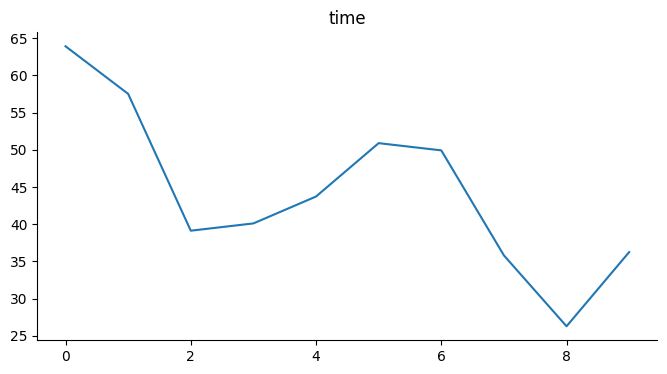

In [29]:
# @title time

from matplotlib import pyplot as plt
results_rag_df['time'].plot(kind='line', figsize=(8, 4), title='time')
plt.gca().spines[['top', 'right']].set_visible(False)

In [30]:
print("\n------\n".join(list(results_rag_df.answer)))

The NVIDIA CUDA Toolkit provides a development environment for creating high-performance GPU-accelerated applications. With the CUDA Toolkit, you can develop, optimize, and deploy your applications on GPU-accelerated embedded systems, desktop workstations, enterprise data centers, cloud-based platforms, and HPC supercomputers. The toolkit includes GPU-accelerated libraries, debugging and optimization tools, a C/C++ compiler, and a runtime library to deploy your application.
------
The CUDA toolkit is a collection of software development tools and libraries provided by Nvidia for developing and optimizing applications that run on Nvidia graphics processing units (GPUs). It includes the CUDA programming language and tools for debugging, profiling, and optimizing CUDA applications. The toolkit also includes a number of pre-built libraries for common tasks such as linear algebra, Fourier transforms, and text processing. Additionally, the toolkit provides a set of pre-defined functions for 

## Documents

- https://www.pinecone.io/learn/series/rag/rerankers/
- https://medium.com/artificial-corner/re-ranking-is-all-you-need-7a6b1e586d48
- https://towardsdatascience.com/forget-rag-the-future-is-rag-fusion-1147298d8ad1
- https://python.langchain.com/docs/integrations/document_transformers/openai_metadata_tagger
- https://langchain-text-splitter.streamlit.app/
- https://www.sbert.net/docs/pretrained_cross-encoders.html


In [ ]:
metadata = {
    "source": "https://www.pinecone.io/learn/series/rag/rerankers/",
    "official_doc": True,
    "official_blog": True,
    "technologies": ['cuda', 'megatron'],
    "operating system": ['windows', 'linux', 'mac']
}